## COMP9727 Project  - WineRec Wine Recommender System

- Yasemin Silen     z5398552  

In [ ]:
# make sure to have libraries installed
#!pip install somoclu

### Import Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pytz
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from minisom import MiniSom                                        # training Self-Organising Maps (SOM)
import somoclu                                                     # training Self-Organising Maps (SOM
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder      # data preprocessing
import ast
import re
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Let's read our two distinct dataset, namely `df_wines` for the wines. Notice that, we are working with the __Full version__ of the datasets:
* `XWines_Full_100K_wines.csv`
* `XWines_Full_21M_ratings.csv` 

As an alternative option, there exists a __Slim version__ of the datasets:
* `XWines_Slim_100K_wines.csv` 
* `XWines_Slim_150K_ratings.csv`

In [3]:
df_wines = pd.read_csv('X-Wines_Dataset/XWines_Full_100K_wines.csv')

df_ratings = pd.read_csv('X-Wines_Dataset/XWines_Full_21M_ratings.csv')

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/1428380662.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ratings = pd.read_csv('X-Wines_Dataset/XWines_Full_21M_ratings.csv')


Let's have quick look at the top 5 rows in our imported wine dataset for both `df_wines` and `df_ratings`. This will give an initial impression of the dataset, providing its attributes, structure and content.

In [4]:
# displays first five rows
df_wines.head()

,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201..."
1,100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200..."
2,100003,Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.0,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10002,Castellamare,https://www.emporiocastellamare.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
3,100004,Virtus Moscato,White,Varietal/100%,['Muscat/Moscato'],['Sweet Dessert'],12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10003,Monte Paschoal,http://www.montepaschoal.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
4,100005,Maison de Ville Cabernet-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",11.0,Full-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10000,Aurora,http://www.vinicolaaurora.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."


In [5]:
# displays last five rows
df_ratings.tail()

,RatingID,UserID,WineID,Vintage,Rating,Date
21013531,21013532,2015383,113302,N.V.,3.0,2019-02-16 14:15:48
21013532,21013533,1868739,111440,N.V.,2.0,2018-09-30 16:47:05
21013533,21013534,1402947,142467,N.V.,3.0,2021-01-29 19:21:14
21013534,21013535,1360350,111440,N.V.,4.0,2021-07-26 14:02:14
21013535,21013536,1192603,111393,N.V.,5.0,2016-11-17 04:48:43


From now on, we will focus exclusively on __Australian wine sources__ and their respective ratings. To do so, we will need to filter both `df_wines` and `australian_ratings` DataFrames as follow:

1. Filter `df_wines` for Australian wine sources;
2. Filter `australian_ratings` to include only the ratings of the filtered Australian wines.

In [6]:
# Filter the DataFrame to get only Australian wines
australian_wines = df_wines[df_wines['Country'] == 'Australia']

# Get the unique identifiers for Australian wines
australian_wine_ids = australian_wines['WineID'].unique()

# Filter the df_ratings DataFrame to get only ratings for Australian wines
australian_ratings = df_ratings[df_ratings['WineID'].isin(australian_wine_ids)]

In [8]:
print(australian_wines.shape)
print(australian_ratings.shape)

australian_wines_ratings.info()

(4818, 17)
(707495, 6)


NameError: name 'australian_wines_ratings' is not defined

Before we start with the __Exploratory Data Analysis (EDA)__, we will perform a merge operation of both `australian_wines` and `australian_ratings` Dataframes on the attribute `WineID`. This ensures that we have a complete dataset to work with.

In [9]:
# Join both datasets
australian_wines_ratings = pd.merge(australian_wines, australian_ratings, on="WineID")

### Exploratory Data Analysis (EDA)

Let's have a quick overview of the DataFrame's structure and contents by applying `info` function. The following command provides a concise summary information on:
1. __Index Range__: The range of the DataFrame index.
2. __Column Names and Data Types__: The names of all columns and their respective data types.
3. __Non-Null Count__: The number of non-null (non-missing) entries in each column.
4. __Memory Usage__: The memory usage of the DataFrame.

In [10]:
australian_wines_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707495 entries, 0 to 707494
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   WineID      707495 non-null  int64  
 1   WineName    707495 non-null  object 
 2   Type        707495 non-null  object 
 3   Elaborate   707495 non-null  object 
 4   Grapes      707495 non-null  object 
 5   Harmonize   707495 non-null  object 
 6   ABV         707495 non-null  float64
 7   Body        707495 non-null  object 
 8   Acidity     707495 non-null  object 
 9   Code        707495 non-null  object 
 10  Country     707495 non-null  object 
 11  RegionID    707495 non-null  int64  
 12  RegionName  707495 non-null  object 
 13  WineryID    707495 non-null  int64  
 14  WineryName  707495 non-null  object 
 15  Website     668028 non-null  object 
 16  Vintages    707495 non-null  object 
 17  RatingID    707495 non-null  int64  
 18  UserID      707495 non-null  int64  
 19  Vi

__Missing Values Analysis__

It's crucial to check for __missing values__ in `australian_wines_ratings` to ensure data quality before  proceeding with any analysis or modeling tasks.

In [11]:
# how many missing values (null values) per attribute?
print(australian_wines_ratings.isna().sum())

WineID            0
WineName          0
Type              0
Elaborate         0
Grapes            0
Harmonize         0
ABV               0
Body              0
Acidity           0
Code              0
Country           0
RegionID          0
RegionName        0
WineryID          0
WineryName        0
Website       39467
Vintages          0
RatingID          0
UserID            0
Vintage           0
Rating            0
Date              0
dtype: int64


Noticeably, there are __missing values__ in the `Website` attribute. We can handle these by replacing each instance with __"No Website"__. Finally, we will double check if all intances of missing values are properly handled.

In [12]:
# Fill missing website information with a placeholder
australian_wines_ratings.loc[australian_wines_ratings['Website'].isna(), 'Website'] = 'No Website'

# check if all missing values (null values) disappears in Website column
print(australian_wines_ratings.isna().sum())

WineID        0
WineName      0
Type          0
Elaborate     0
Grapes        0
Harmonize     0
ABV           0
Body          0
Acidity       0
Code          0
Country       0
RegionID      0
RegionName    0
WineryID      0
WineryName    0
Website       0
Vintages      0
RatingID      0
UserID        0
Vintage       0
Rating        0
Date          0
dtype: int64


__Summary Statistics__

Let's have a look on summary statistics by applying `describe` function on `australian_wines_ratings`. For the purpose of __readability__ we apply transpose `T` operation.

The descriptive statistics summarizes important information such as __central tendency__, __dispersion__, and __shape__ of the dataset’s distribution, __excluding NaN values__.

In [13]:
# summary statistics
australian_wines_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
WineID,707495.0,1.747640e+05,2.449875e+03,101407.0,174241.0,174464.0,175087.0,199697.0
ABV,707495.0,1.379660e+01,1.126200e+00,0.5,13.5,14.0,14.5,21.5
RegionID,707495.0,2.158071e+03,1.078494e+02,2094.0,2112.0,2144.0,2158.0,2741.0
WineryID,707495.0,6.366831e+04,2.474824e+03,10502.0,63097.0,63684.0,64561.0,71453.0
RatingID,707495.0,1.074641e+07,6.067215e+06,145.0,5529049.0,11236619.0,15987095.0,21013530.0
UserID,707495.0,1.441384e+06,3.071565e+05,1000001.0,1194459.0,1363909.0,1700911.0,2063383.0
Rating,707495.0,3.812515e+00,7.467724e-01,1.0,3.5,4.0,4.0,5.0


Additionally, we can create a __descriptive statistics__ for the __categorical (object-type) columns__ (i.e. the non-numeric columns). As a result, we can quickly recognise the __most frequent categories__ and their prevalence in `australian_wines_ratings`. The output displays the the following for each categorical column:
* __Count__: The number of non-null entries.
* __Unique__: The number of unique values.
* __Top__: The most frequent value.
* __Freq__: The frequency of the most frequent value.


In [14]:
# Summary Statistics for Categorical Columns
australian_wines_ratings.describe(include=['O'])

,WineName,Type,Elaborate,Grapes,Harmonize,Body,Acidity,Code,Country,RegionName,WineryName,Website,Vintages,Vintage,Date
count,707495,707495,707495,707495,707495,707495,707495,707495,707495,707495,707495,707495,707495,707495,707495
unique,3352,6,10,360,139,5,3,1,1,92,1316,934,4037,71,706057
top,Shiraz,Red,Varietal/100%,['Syrah/Shiraz'],"['Beef', 'Lamb', 'Game Meat', 'Poultry']",Very full-bodied,High,AU,Australia,South Eastern Australia,Penfolds,https://www.penfolds.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",2016,2012-07-19 12:31:38
freq,47766,566404,515373,258496,267784,313724,618758,707495,707495,115227,47079,47079,13190,84782,5


__Distribution of Wine Types__

Let's create a __bar plot__ to visualse the distribution of different wine types in the `australian_wines` DataFrame using `matplotlib` in conjuction with `seaborn`. Noticeably, the __red wine is the most popular__ type of wine amongst all the wines.

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/583727869.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wine_type_counts.index, y=wine_type_counts.values, palette='muted')


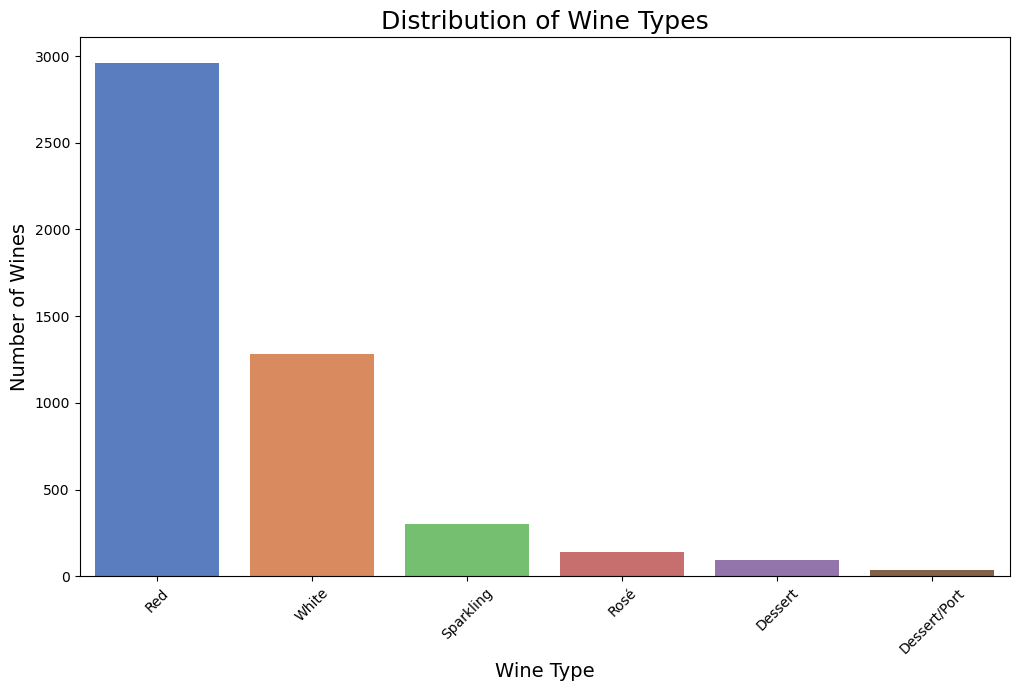

In [15]:
plt.figure(figsize=(12, 7))
wine_type_counts = australian_wines['Type'].value_counts()
sns.barplot(x=wine_type_counts.index, y=wine_type_counts.values, palette='muted')
plt.title('Distribution of Wine Types', fontsize=18)
plt.ylabel('Number of Wines', fontsize=14)
plt.xlabel('Wine Type', fontsize=14)
plt.xticks(rotation=45)     # rotate 45 degrees for better readability
plt.show()

__Pie Chart for Wine Types__

__Pie charts__ are super popular to convey __readability__ and __interpretability__ in a intuitive visual representation of the __distribution of wine types__. So below we display another way of visualising the wine types' distribuition.

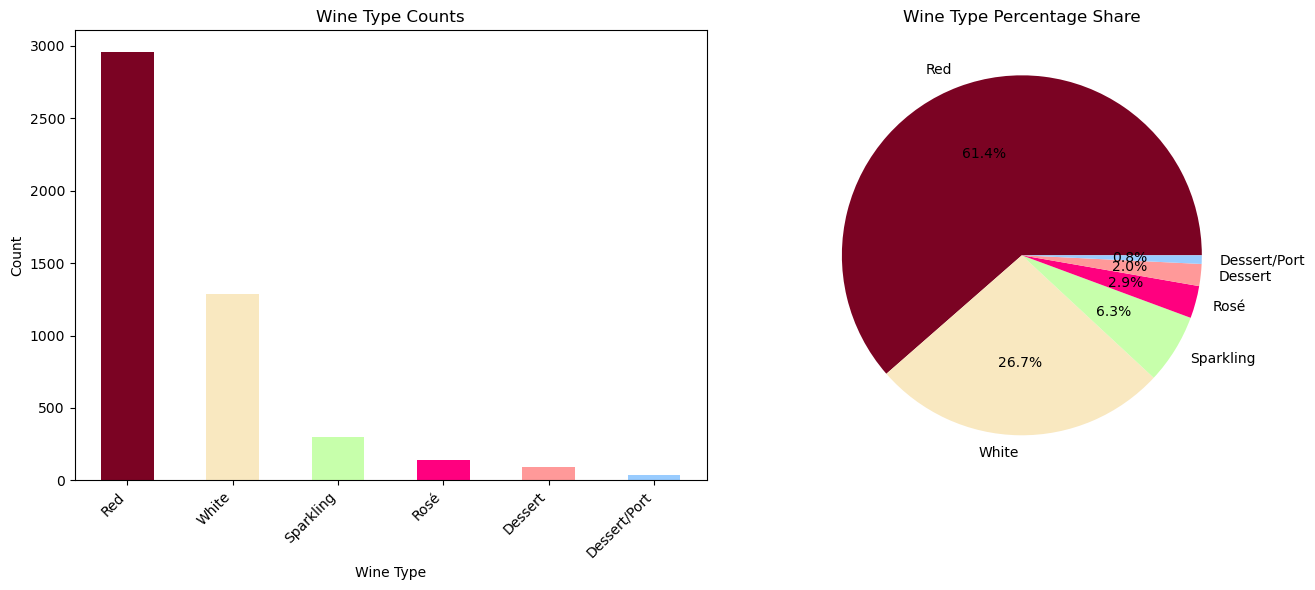

In [16]:
wine_type_counts = australian_wines['Type'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
wine_type_counts.plot(kind='bar', ax=ax[0], color=['#7B0323','#F9E8C0','#C7FFAB', '#FF007F', '#FF9999', '#99CCFF'])
ax[0].set_title('Wine Type Counts')
ax[0].set_xlabel('Wine Type')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

# Pie chart
wine_type_counts.plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                      colors=['#7B0323','#F9E8C0','#C7FFAB', '#FF007F', '#FF9999', '#99CCFF'])
ax[1].set_title('Wine Type Percentage Share')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

__Distribution of Wine Ratings__

Let's effectively create a histogram to visualize the distribution of wine ratings in the `australian_wines_ratings` DataFrame by applying `matplotlib`. This provides a clear intuitive representation of how wine ratings are distributed. Additionally, we have decided to __highlight proportions__ to enhance readability, by annotating percentage labels to the bars for each rating. 

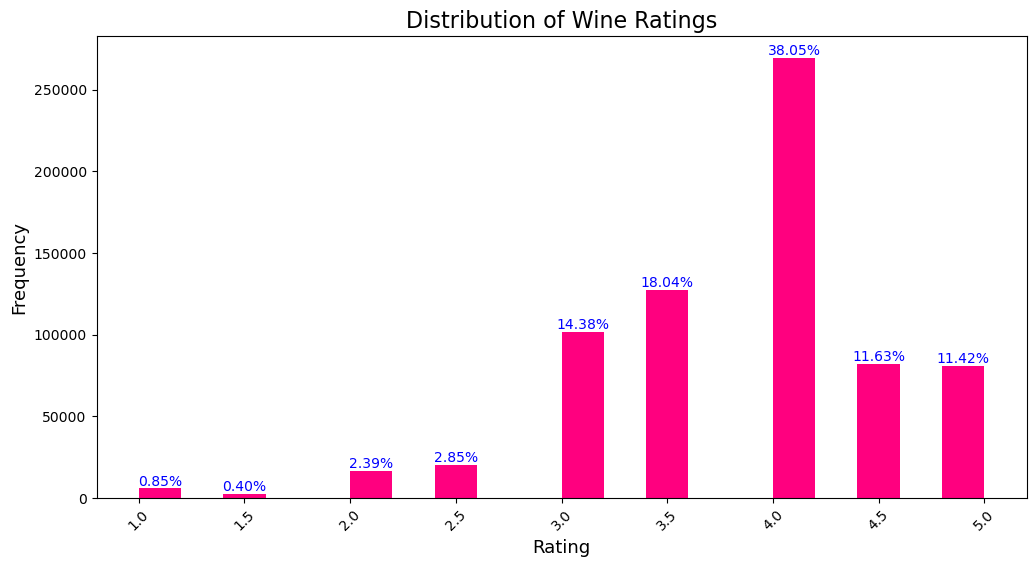

In [17]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(australian_wines_ratings['Rating'], bins=20, color='#FF007F')

# Adding percentage labels only to non-zero bars
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for count, x in zip(n, bin_centers):
    if count > 0:
        plt.text(x, count, f'{count / n.sum() * 100:.2f}%', ha='center', va='bottom', color='blue')

plt.title('Distribution of Wine Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(rotation=45)     # rotate 45 degrees for better readability
plt.show()


__Wine Ratings Over Time: Time Series Analysis__

Let's examine how average wine ratings have evolved over time in the `australian_wines_ratings` DataFrame. Here we are interested in grouping the wine ratings by the average rating for each month. Thus, it easily displays __trends__, __seasonal variations__ and __anomalies__. Noticeably, we can identify that on average __highest ratings__ happened in mid-2012, whereas the __lowest ratings__ in the beginning of 2012.

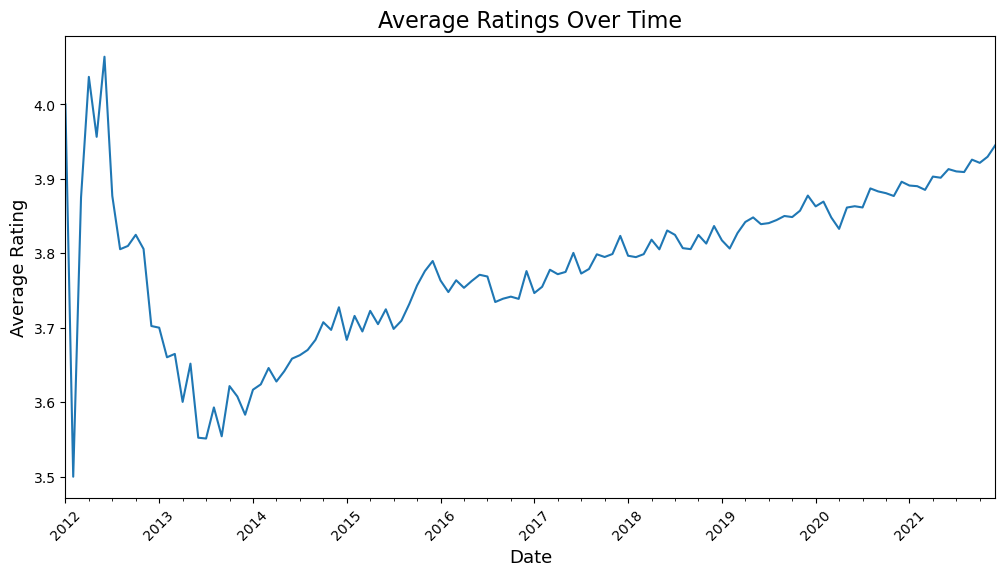

In [18]:
# Ratings Over Time Analysis
australian_wines_ratings['Date'] = pd.to_datetime(australian_wines_ratings['Date'])
ratings_over_time = australian_wines_ratings.groupby(australian_wines_ratings['Date'].dt.to_period("M")).mean(numeric_only=True)['Rating']

plt.figure(figsize=(12, 6))
ratings_over_time.plot()
plt.title('Average Ratings Over Time', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Average Rating', fontsize=13)
plt.xticks(rotation=45)     # rotate 45 degrees for better readability
plt.show()

__Grape Analysis__

Let's highlight the __top 20 grape varieties by count__ in `australian_wines_ratings['Grapes']`. This gives insights into the __popularity of different grapes__ in Australian wines.

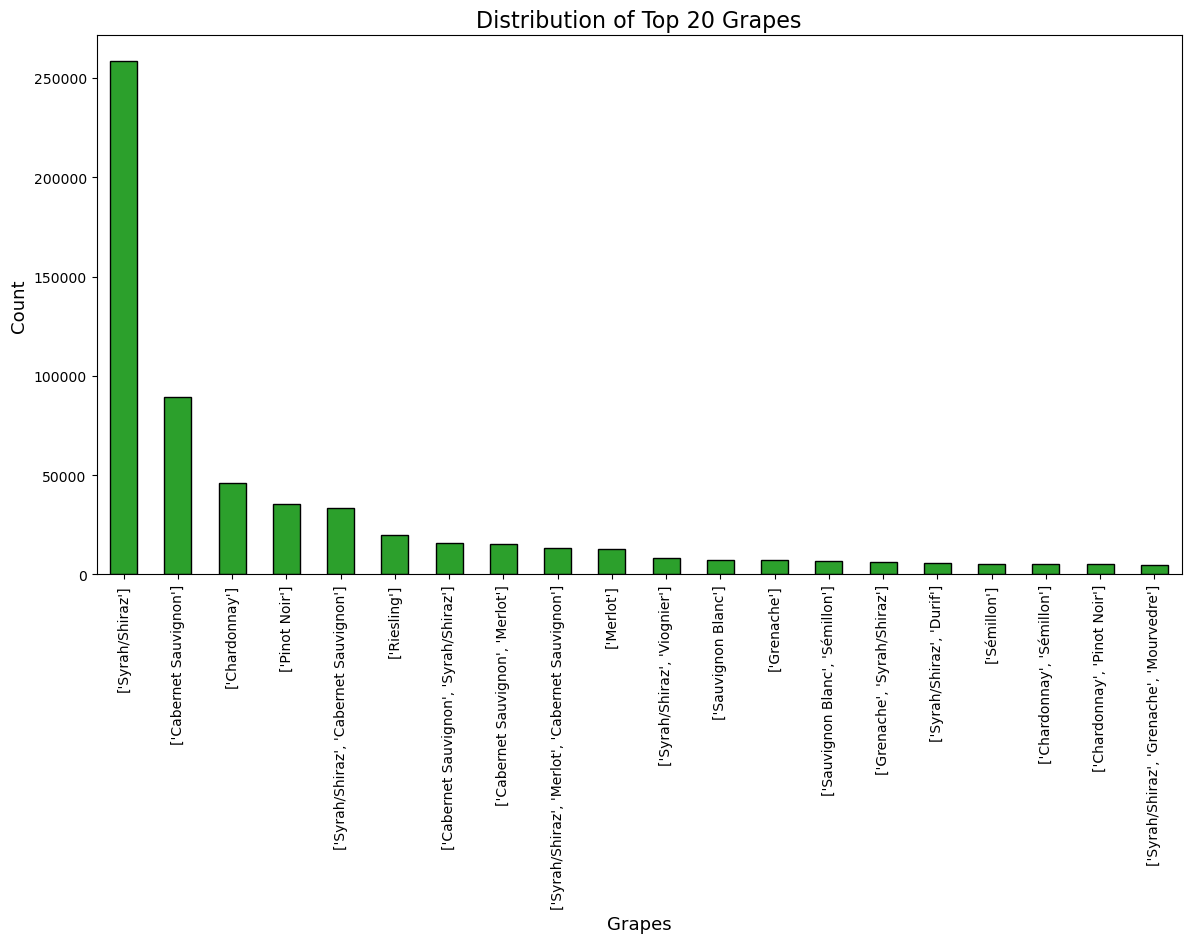

In [19]:
# Distribution of Grapes using a sample of top 20 grapes by count
top_grapes_by_count = australian_wines_ratings['Grapes'].value_counts().head(20)

plt.figure(figsize=(14, 7))
top_grapes_by_count.plot(kind='bar', color='#2ca02c', edgecolor='black')
plt.title('Distribution of Top 20 Grapes', fontsize=16)
plt.xlabel('Grapes', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

Some of the elected instances in the top-20 ranking were blend of multiple grape types. What if we could analyse a __top-10 ranking of individual grapes__? 

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/486970740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  australian_wines['Grapes'] = australian_wines['Grapes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/486970740.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_grapes.index, y=top_grapes.values, palette='viridis')


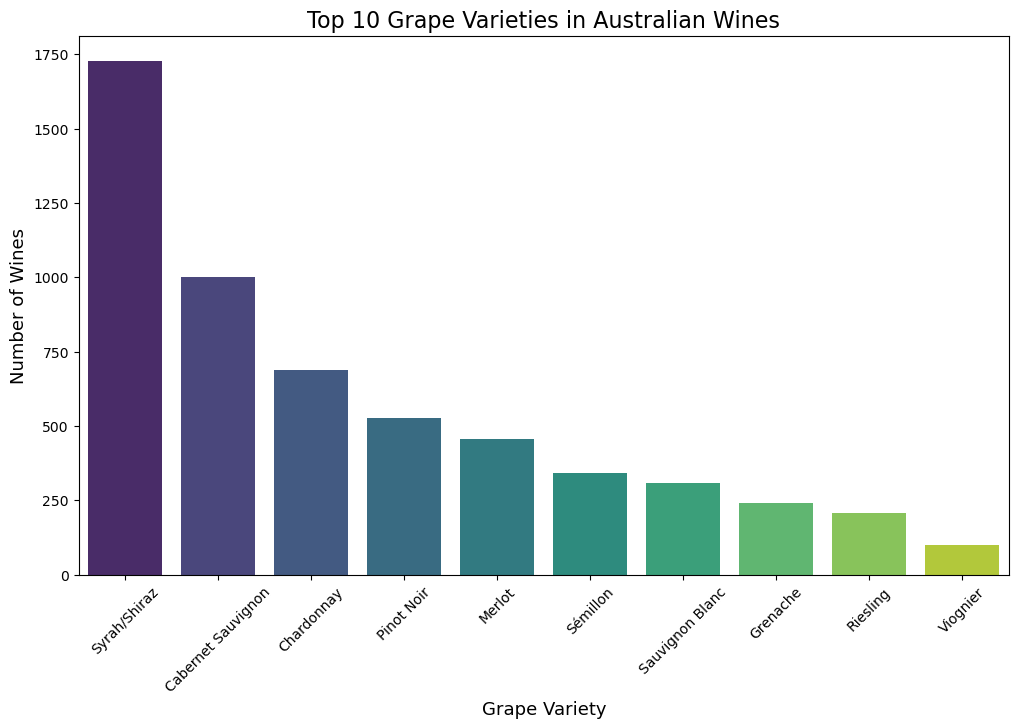

In [20]:
import ast

if 'Grapes' in australian_wines.columns:
    australian_wines['Grapes'] = australian_wines['Grapes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    grape_varieties = australian_wines.explode('Grapes')

    # Top 10 grape varieties by wine count (individual grape)
    top_grapes = grape_varieties['Grapes'].value_counts().head(10)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=top_grapes.index, y=top_grapes.values, palette='viridis')
    plt.title('Top 10 Grape Varieties in Australian Wines', fontsize=16)
    plt.ylabel('Number of Wines', fontsize=13)
    plt.xlabel('Grape Variety', fontsize=13)
    plt.xticks(rotation=45)
    plt.show()
else:
    print("The 'Grapes' column is missing.")

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/1924765671.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ratings_by_top_grapes.index, y=avg_ratings_by_top_grapes.values, palette='muted')


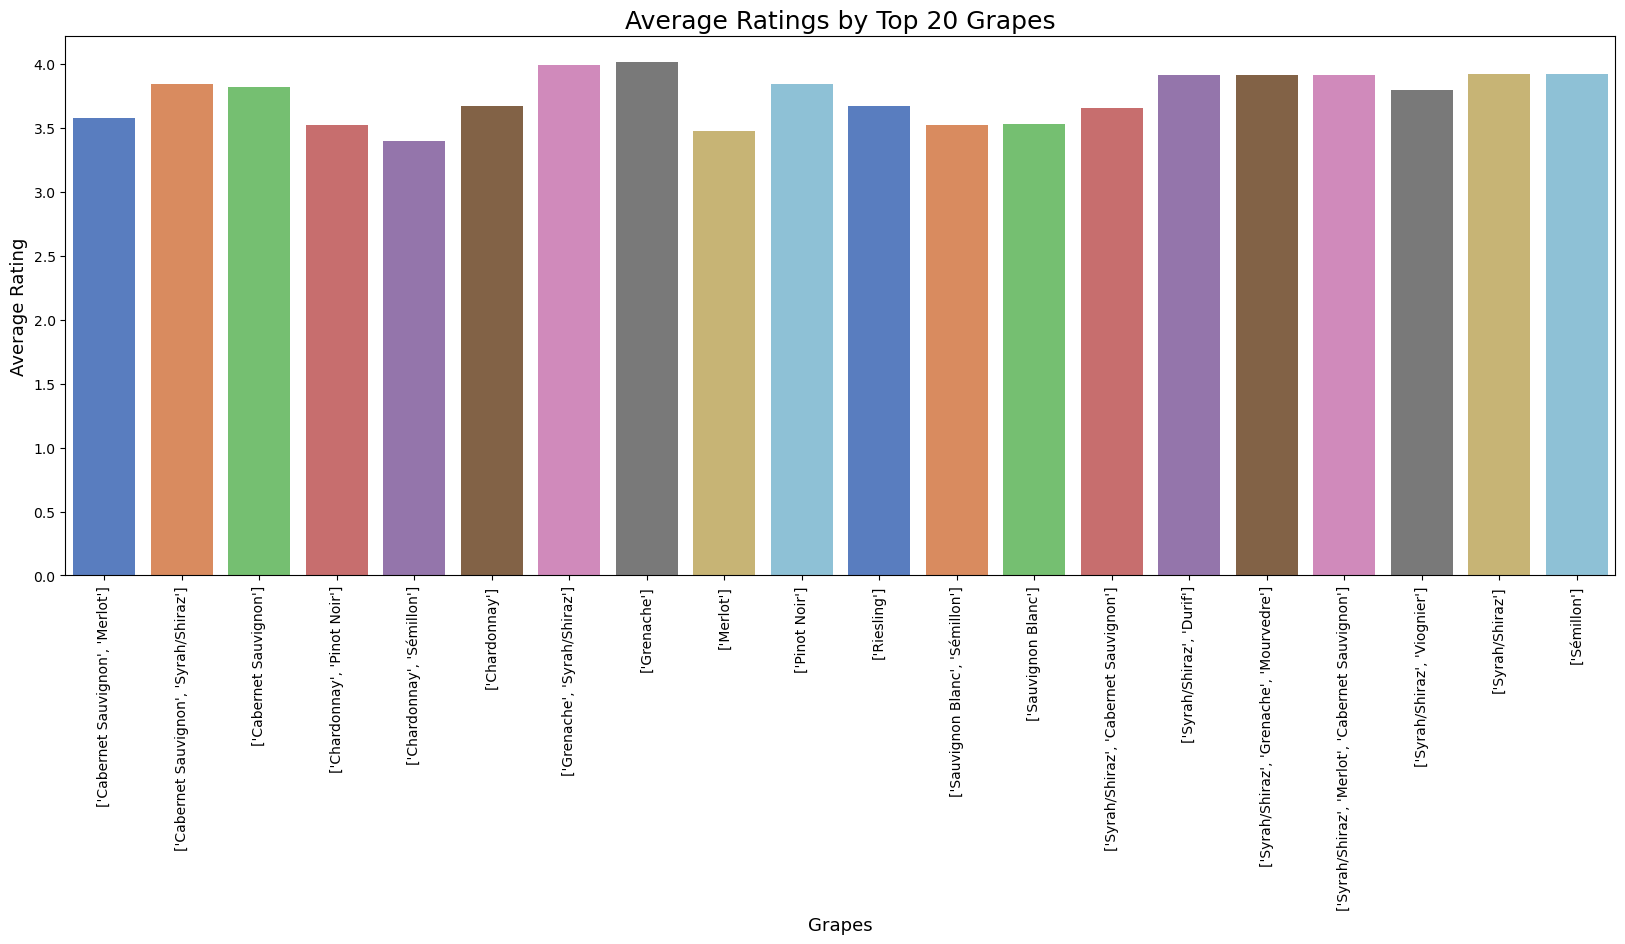

In [21]:
# Average ratings by grapes using a sample of top 20 grapes by count
avg_ratings_by_top_grapes = australian_wines_ratings[australian_wines_ratings['Grapes'].isin(top_grapes_by_count.index)].groupby('Grapes')['Rating'].mean()

plt.figure(figsize=(20, 7))
sns.barplot(x=avg_ratings_by_top_grapes.index, y=avg_ratings_by_top_grapes.values, palette='muted')
plt.title('Average Ratings by Top 20 Grapes', fontsize=18)
plt.ylabel('Average Rating', fontsize=13)
plt.xlabel('Grapes', fontsize=13)
plt.xticks(rotation=90)     # rotate 90 degrees for better readability
plt.show()


__Distribution of ABV (Alcohol by Volume)__

Let's create a __histogram__ to visualise the distribution of __Alcohol by Volume (ABV)__ for __Australian wines__ in `australian_wines`. Additionally, it overlays with the __Kernel Density Estimate (KDE)__.

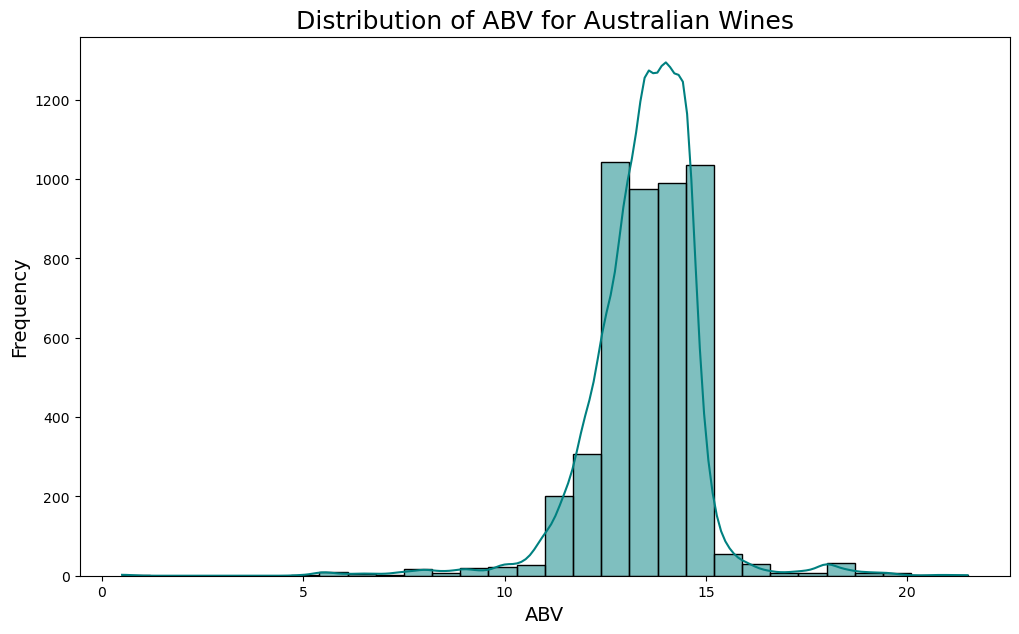

In [22]:
# distribution of ABV for Australian wines
plt.figure(figsize=(12, 7))
sns.histplot(australian_wines['ABV'], kde=True, bins=30, color='teal', edgecolor='black')
plt.title('Distribution of ABV for Australian Wines', fontsize=18)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('ABV', fontsize=14)
plt.show()

__Correlation between ABV and ratings__

Let's create a __scatter plot__ to show the relationship between Alcohol by Volume (ABV) and wine ratings. Below we have the following insights:

* __Trend__:
The analysis on the scatter plot shows points spread out across various ABV levels for each rating. There is no clear upward or downward trend in the scatter of points. Thus, it suggests a __weak correlation__ between ABV and ratings. 

* __Density of data points__: Some rating levels (i.e. 3.0, 4.0, 4.5) have a higher density of points compared to others. This indicates that these ratings are more common in the dataset.

* __Range of ABV Values__: The ABV values range from 0 to approximately 20. Most of the data points seem to cluster between ABV values of 10 to 15.

* __Correlation Coefficient__: The correlation matrix shown below the plot indicates a __weak positive correlation of 0.163__ between ABV and ratings. This is consistent with the lack of a clear trend in the scatter plot. A correlation coefficient close to 0 indicates that there's little to __no linear relationship__ between ABV and wine ratings.

Therefore, the scatter plot and correlation analysis suggest that ABV is __not a strong predictor of wine ratings__. This indicates that while ABV might contribute to the overall quality of the wine, other factors are likely more important in determining wine ratings. Further analysis could involve exploring these other factors (for instance, type, region, grapes) to gain more insights into what drives higher wine ratings.

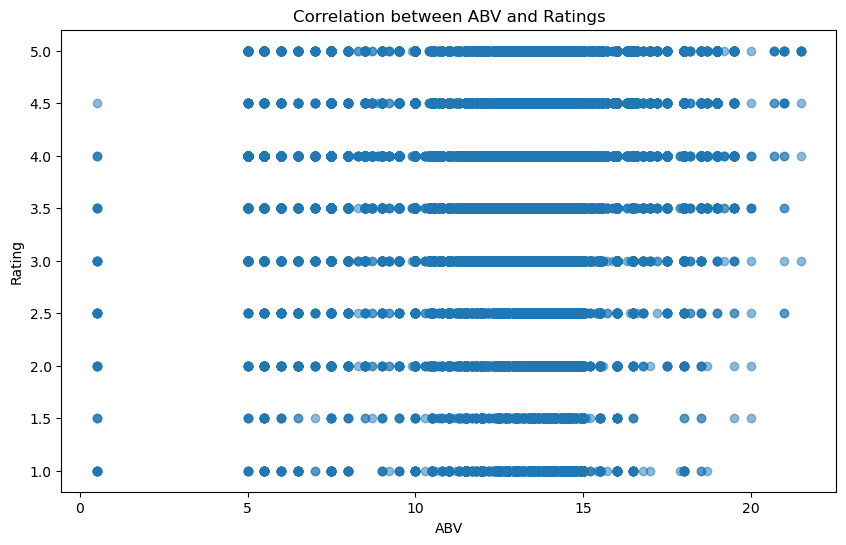

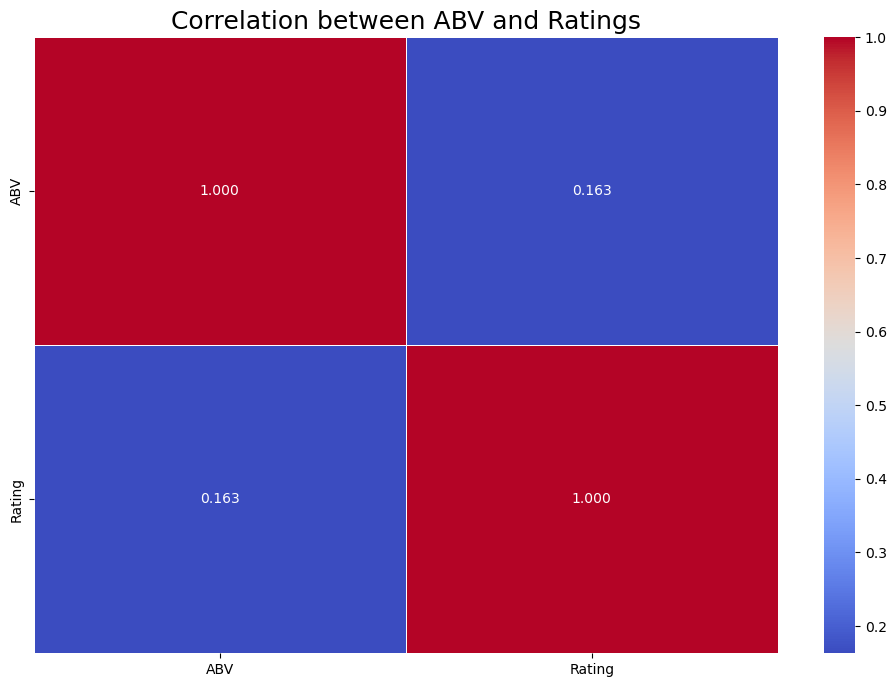

In [23]:
# Correlation between ABV and ratings
plt.figure(figsize=(10, 6))
plt.scatter(australian_wines_ratings['ABV'], australian_wines_ratings['Rating'], alpha=0.5)
plt.title('Correlation between ABV and Ratings')
plt.xlabel('ABV')
plt.ylabel('Rating')
plt.show()

# correlation matrix
correlation_abv_rating = australian_wines_ratings[['ABV', 'Rating']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_abv_rating, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title('Correlation between ABV and Ratings', fontsize=18)
plt.show()

__Winery Analysis: Top 10 Wineries by Number of Wines (Wineries' Portfolio Size)__

Let's creates a __bar plot__ to visualise the top 10 wineries based on the number of wines they have in `australian_wines`. As a result we can gain some valuable insights into the most prolific wineries in terms of wine production. Notice that, `australian_wines` lists wines as individual data points, __without considering how many times each wine has been rated__. Therefore, it represents the __variety of wines produced by each winery__ rather than their popularity or number of ratings. 

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/2126995767.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_wineries.index, y=top_wineries.values, palette='coolwarm')


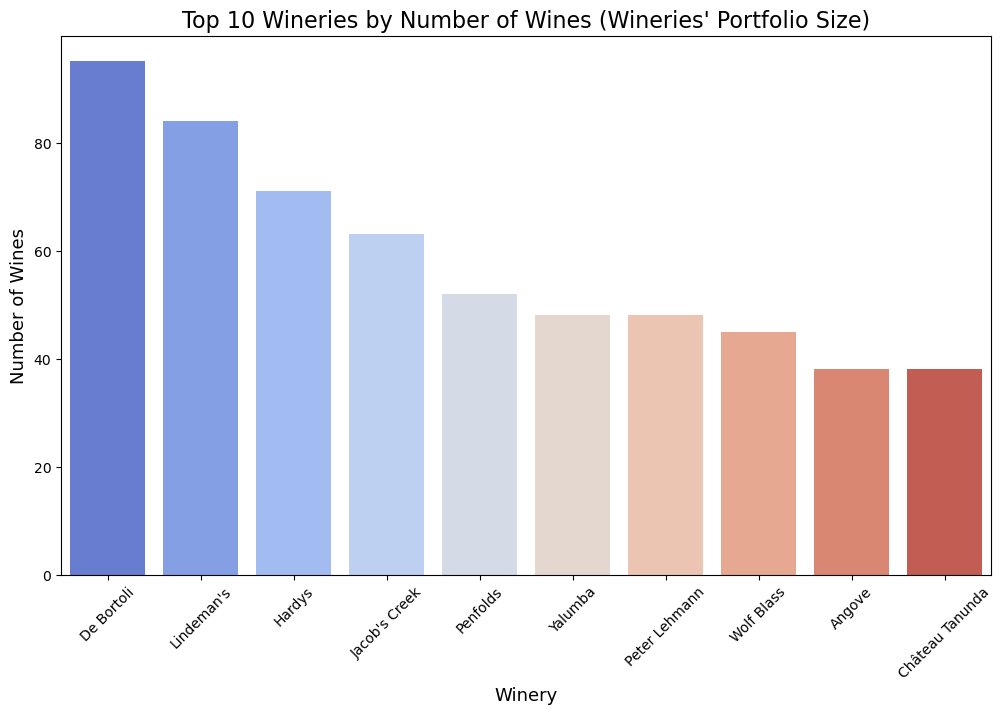

In [24]:
# Top-10 Wineries by number of Wines
top_wineries = australian_wines['WineryName'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_wineries.index, y=top_wineries.values, palette='coolwarm')
plt.title("Top 10 Wineries by Number of Wines (Wineries' Portfolio Size)", fontsize=16)
plt.ylabel('Number of Wines', fontsize=13)
plt.xlabel('Winery', fontsize=13)
plt.xticks(rotation=45)
plt.show()

__Winery Analysis: Top 10 Wineries by Frequency of Ratings Received (Wineries' Popularity)__

Let's creates a __bar plot__ to visualise the top 10 wineries based on the frequency of rated wines in `australian_wines`. This contains ratings for wines, including winery names and the number of times each wine has been rated. Notice that, `australian_wines` represents __user ratings__, indicating the __popularity__ and frequency of ratings for wines from different wineries. Therefore, it reflects __how often wines from each winery are rated,__ not just the diversity of their wine offerings.

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/1231331122.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=winery_counts.index, y=winery_counts.values, palette='coolwarm')


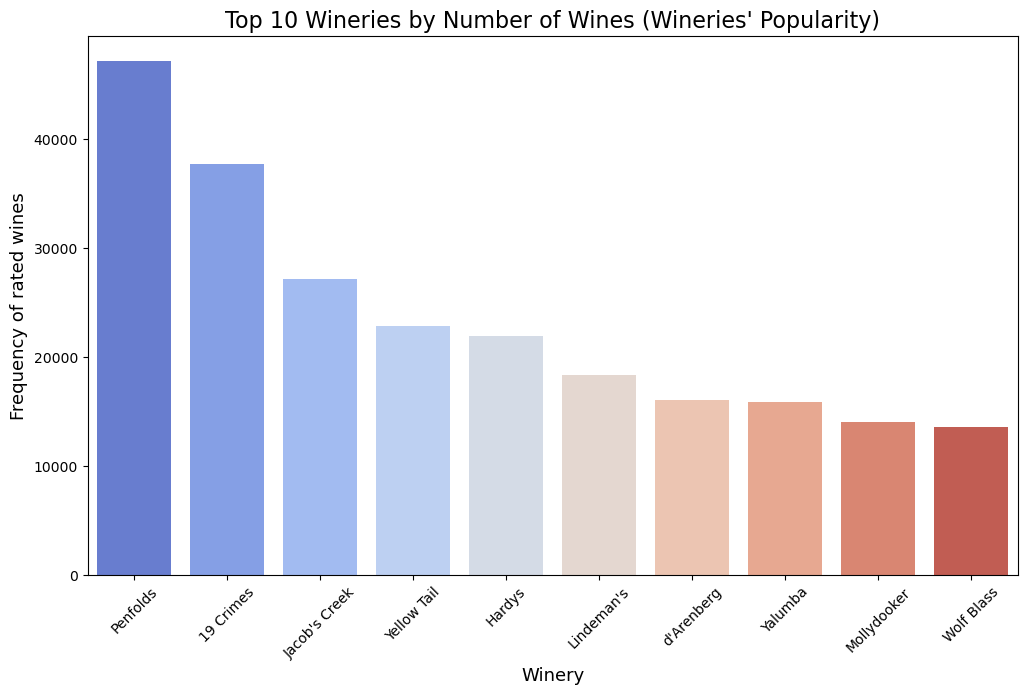

In [25]:
# Distribution of Wines by Top 10 Wineries
winery_counts = australian_wines_ratings['WineryName'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=winery_counts.index, y=winery_counts.values, palette='coolwarm')
plt.title("Top 10 Wineries by Number of Wines (Wineries' Popularity)", fontsize=16)
plt.ylabel('Frequency of rated wines', fontsize=13)
plt.xlabel('Winery', fontsize=13)
plt.xticks(rotation=45)
plt.show()

__Winery Analysis: Wineries' Popularity vs. Portfolio Size__

Wineries, in particular De Bortoli and Lindeman's in `australian_wines` might produce a __large variety of wines__, but they might not be rated as frequently as others. More specifically, __De Bortoli__ ranks at the top in `australian_wines` with 95 wines but does not appear in the top 10 of `australian_wines_ratings`, suggesting a large portfolio but possibly lower user engagement or fewer ratings per wine.

On the other hand, Wineries such as Penfolds and 19 Crimes in `australian_wines_ratings` might have fewer wine varieties but are __highly popular and frequently rated by users__. Specifically, __Penfolds__ appears in both DataFrames but shows a stark difference in counts (52 in `australian_wines` against 47,079 in `australian_wines_ratings`). This indicates that while Penfolds may not have the most diverse portfolio, its wines are highly popular and frequently rated.

__Winery Analysis: Average Wine Ratings For Top 20 Wineries By Number Of Ratings__

Let's creates a __bar plot__ to visualize the average wine ratings for the top 20 wineries by number of ratings in `australian_wines_ratings`. This highlights the average ratings for wines from the top 20 wineries by number of ratings. Thus, it offers valuable insights into the __perceived quality of these wineries__.

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/47004090.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ratings_by_top_wineries.index, y=avg_ratings_by_top_wineries.values, palette='muted')


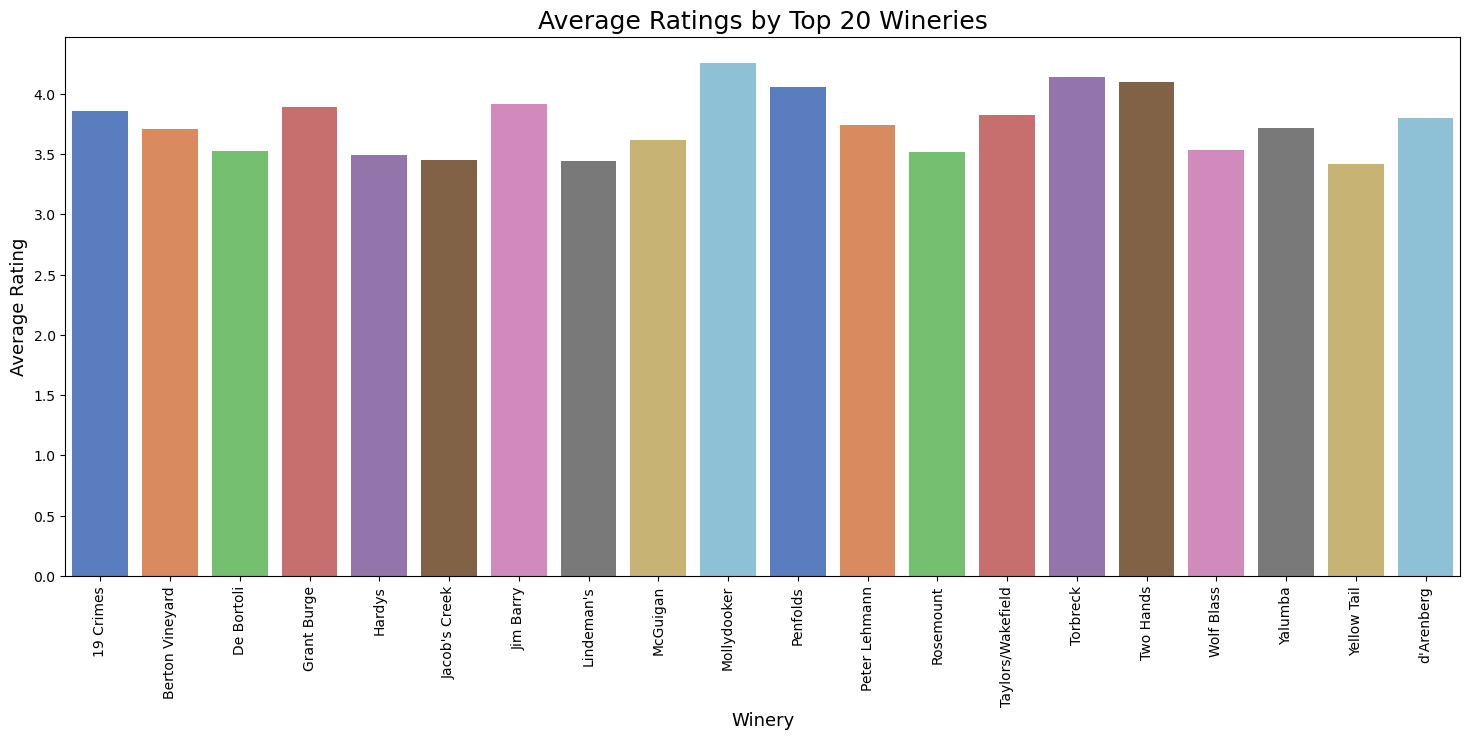

In [26]:
# Average Ratings by Top 20 Wineries
top_wineries_by_count = australian_wines_ratings['WineryName'].value_counts().head(20).index
avg_ratings_by_top_wineries = australian_wines_ratings[australian_wines_ratings['WineryName'].isin(top_wineries_by_count)].groupby('WineryName')['Rating'].mean()


plt.figure(figsize=(18, 7))
sns.barplot(x=avg_ratings_by_top_wineries.index, y=avg_ratings_by_top_wineries.values, palette='muted')
plt.title('Average Ratings by Top 20 Wineries', fontsize=18)
plt.ylabel('Average Rating', fontsize=13)
plt.xlabel('Winery', fontsize=13)
plt.xticks(rotation=90)     # rotate 90 degrees for better readability
plt.show()

__Body Analysis: Distribution of Wine Body (Variety Of Wines Produced)__

Let's create a __bar plot__ to visualize the distribution of __wines available with different body characteristics__ in `australian_wines`  by applying `seaborn`. This measures the number of __unique wines__ with each body characteristic. Therefore, it reflects the __variety of wines produced__ rather than their popularity.

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/2283521178.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=body_counts.index, y=body_counts.values, palette='coolwarm')


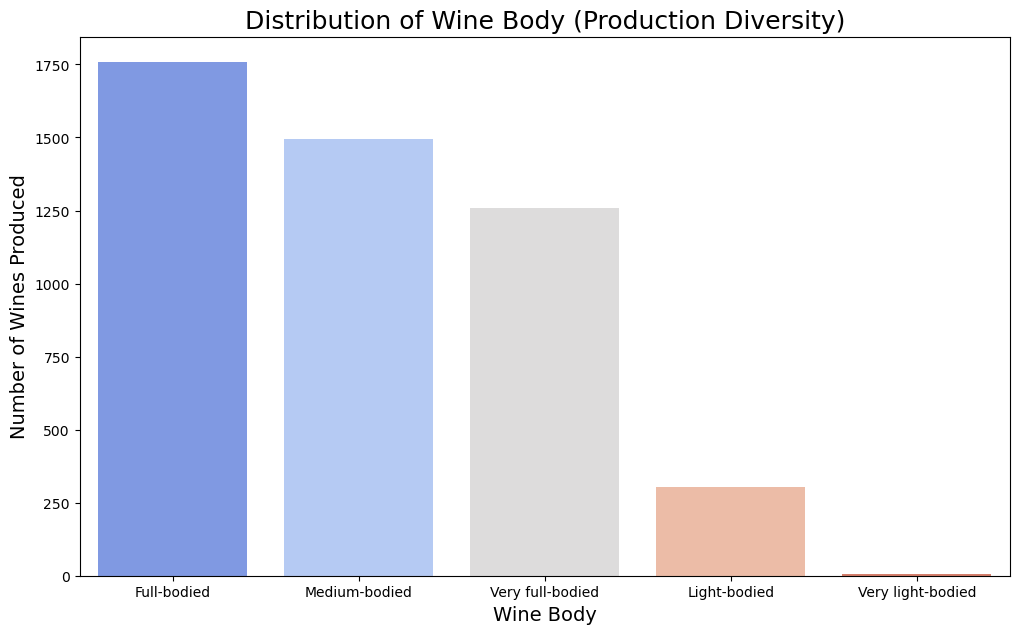

In [27]:
# Distribution of Wine Body (Variety Produced)
plt.figure(figsize=(12, 7))
body_counts = australian_wines['Body'].value_counts()
sns.barplot(x=body_counts.index, y=body_counts.values, palette='coolwarm')
plt.title('Distribution of Wine Body (Production Diversity)', fontsize=18)
plt.ylabel('Number of Wines Produced', fontsize=14)
plt.xlabel('Wine Body', fontsize=14)
plt.show()

__Body Analysis: Distribution of Wine Body (Popularity, User Engagement)__

Let's create a __bar plot__ to visualize the distribution of __how often wines with different body characteristics are rated__ in `australian_wines`  by applying `seaborn`. This reflects __user interactions and ratings__, which indicates the __popularity__ and frequency of ratings for wines with different body characteristics. Therefore, it displays higher counts for certain body characteristics that are more popular or frequently rated by users.

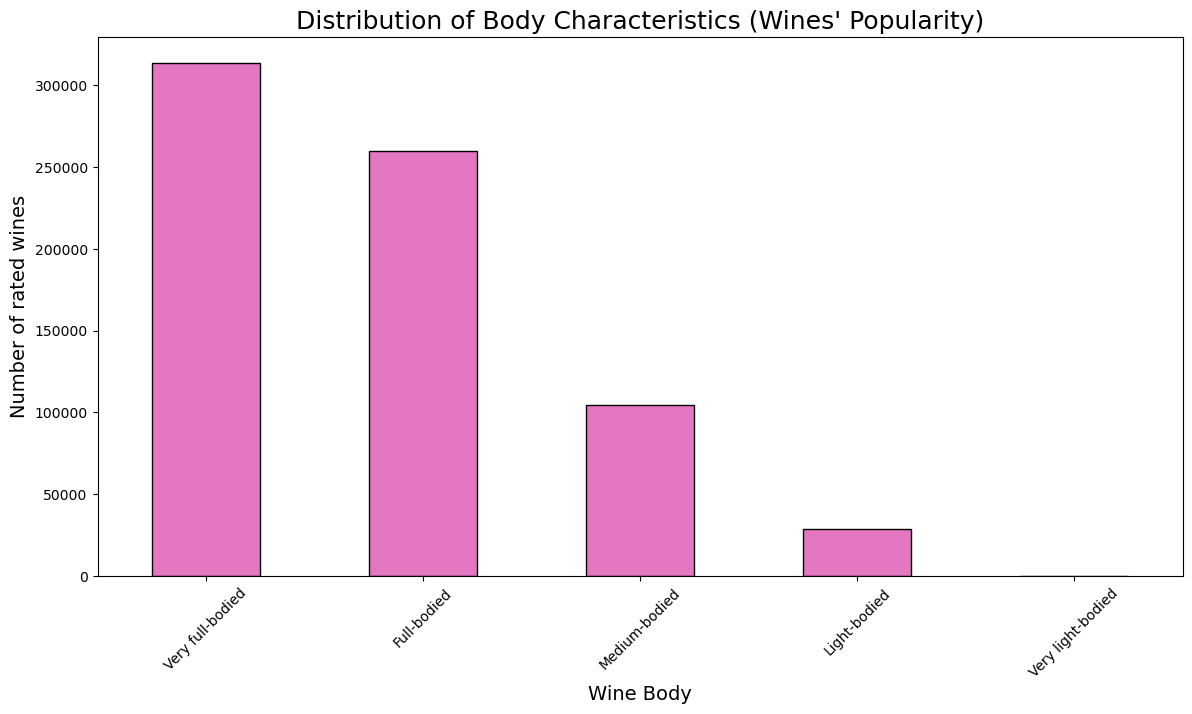

In [28]:
# Distribution of body characteristics (Popularity, User Engagement)
plt.figure(figsize=(14, 7))
body_counts = australian_wines_ratings['Body'].value_counts()
body_counts.plot(kind='bar', color='#e377c2', edgecolor='black')
plt.title("Distribution of Body Characteristics (Wines' Popularity)", fontsize=18)
plt.xlabel('Wine Body', fontsize=14)
plt.ylabel('Number of rated wines', fontsize=14)
plt.xticks(rotation=45)
plt.show()

__Body Analysis: Insights__

* __Popularity Vs. Production__: Some wine bodies, particularly Very full-bodied wines, are highly popular despite lower production volumes compared to Full-bodied wines.

* __User Preferences__: It seem to favor very Full-bodied wines the most, followed by Full-bodied and Medium-bodied wines.

* __Market Demand Vs. Supply__: The market demand (indicated by ratings) for very full-bodied wines is exceptionally high. Thus, it suggests that wineries might consider increasing the production of these wines to meet consumer preferences.

* __Less Popular Wines__: Light-bodied and Very light-bodied wines are less popular, as reflected by both lower production and fewer ratings. This might suggest a niche market for these wines or a need for marketing strategies to boost their popularity.


__Acidity Analysis: Distribution of Wine Acidity (Variety Of Wines Produced)__

Let's create a __bar plot__ to visualize the distribution of the number of __ wines produced with each acidity level__ in `australian_wines`  by applying `seaborn`. This measures the number of __unique wines__ with each acidity class. Therefore, it reflects the __variety of wines produced__ rather than their popularity.

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/3081552001.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acidity_counts.index, y=acidity_counts.values, palette='magma')


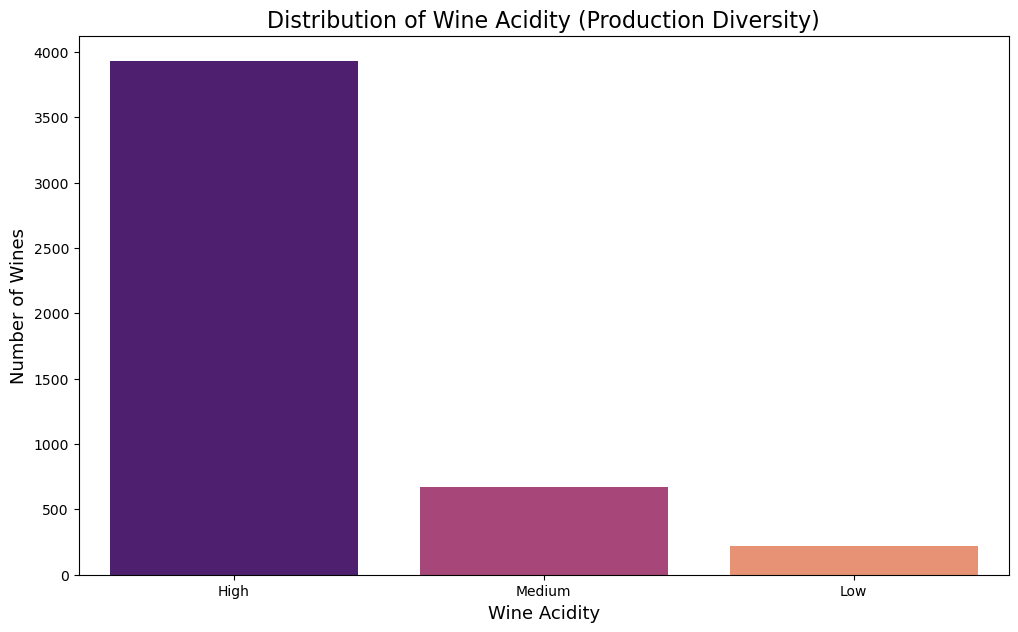

In [29]:
# Distribution of different wine acidity levels
plt.figure(figsize=(12, 7))
acidity_counts = australian_wines['Acidity'].value_counts()
sns.barplot(x=acidity_counts.index, y=acidity_counts.values, palette='magma')
plt.title('Distribution of Wine Acidity (Production Diversity)', fontsize=16)
plt.ylabel('Number of Wines', fontsize=13)
plt.xlabel('Wine Acidity', fontsize=13)
plt.show()

__Acidity Analysis: Distribution of Wine Acidity (Popularity, User Engagement)__

Let's create a __bar plot__ to visualize the distribution of the number of __the number of ratings received by wines with each acidity level__ in `australian_wines`  by applying `seaborn`. This reflects __user interactions and ratings__, which indicates the __popularity__ and frequency of ratings for wines with different acidity characteristics. Therefore, it displays higher counts for certain acidity properties that are more popular or frequently rated by users.

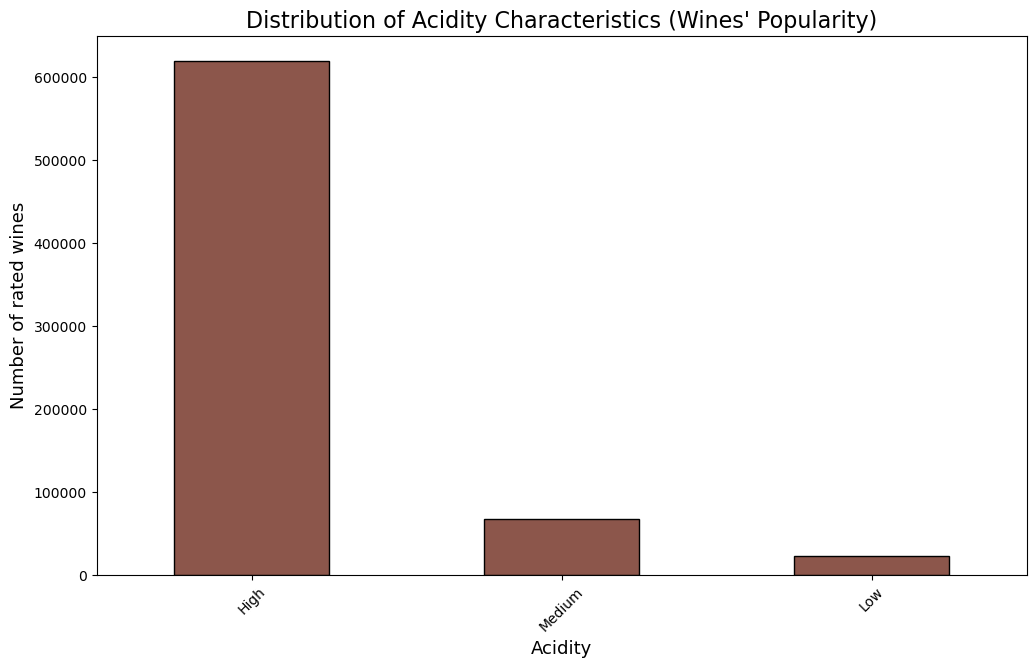

In [30]:
# Distribution of acidity and body characteristics (Popularity, User Engagement)
plt.figure(figsize=(12, 7))
acidity_counts = australian_wines_ratings['Acidity'].value_counts()
acidity_counts.plot(kind='bar', color='#8c564b', edgecolor='black')
plt.title("Distribution of Acidity Characteristics (Wines' Popularity)", fontsize=16)
plt.xlabel('Acidity', fontsize=13)
plt.ylabel('Number of rated wines', fontsize=13)
plt.xticks(rotation=45)     # rotate 45 degrees for better readability
plt.show()

__Acidity Analysis: Insights__

* __Popularity Vs. Production__: High acidity wines are the most produced (3,928 wines) and also they receive an overwhlemingly high number of ratings (618,758). Meanwhile, Medium acidity wines have a moderate production volume (672 wines) while they receive a significant but much lower number of ratings (66,779), which shows moderate popularity. Lastly, Low acidity wines are the least produced (218 wines) whereas they receive the fewest ratings (21,958), which indicates that they are less popular among users.  

* __User Preferences__: There is a clear user preference for High acidity wines, as evidenced by the significant amount of ratings they receive compared to other acidity levels.

* __Market Demand Vs. Supply__: The extremely high number of ratings for High acidity wines suggests that wineries are effectively meeting a significant market demand. This demand is much greater than that for Medium or Low acidity wines.

* __Less Popular Wines__: Low acidity wines are the least produced and least popular, suggesting they cater to a smaller, niche market.

* __Insights for Wineries__: Wineries may consider focusing more on High acidity wines to capitalize on their popularity and meet consumer demand. While high acidity wines are in demand, maintaining a diverse portfolio that includes Medium and Low acidity wines can cater to niche markets and varied consumer preferences.


__Correlation Matrix: Acidity Vs. Body Vs. Ratings__

Overall, the result of the computed correlation matrix on the Acidity, Body and Ratings shows __weak correlations__ (values close to 0), which indicates that these factors have minimal direct linear relationships with wine ratings.

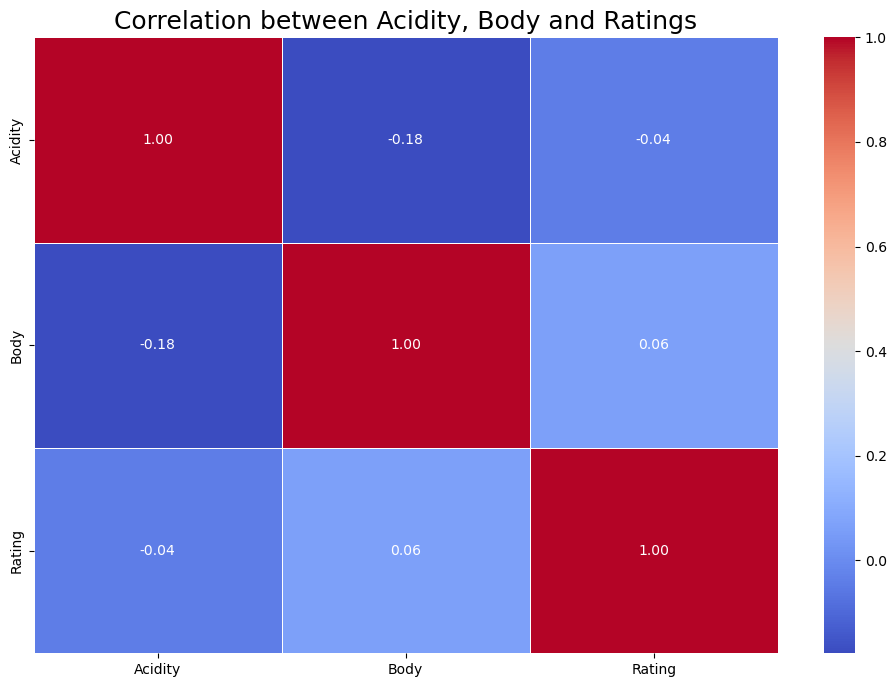

In [31]:
# Correlation between acidity/body and ratings
acidity_body_rating = australian_wines_ratings[['Acidity', 'Body', 'Rating']].copy()
acidity_body_rating['Acidity'] = acidity_body_rating['Acidity'].astype('category').cat.codes
acidity_body_rating['Body'] = acidity_body_rating['Body'].astype('category').cat.codes

# correlation
correlation_acidity_body_rating = acidity_body_rating.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_acidity_body_rating, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation between Acidity, Body and Ratings', fontsize=18)
plt.show()

__Regional Analysis: Distribution of Wines by Region (based on Popularity, User Engagement)__

Let's creates a __bar plot__ to visualize the __distribution of wines by region__ in `australian_wines` by applying `seaborn`. Thus, it focuses on the total number of ratings received by wines from each region, reflecting the overall __popularity__ and __user engagement__ with wines from those regions. 

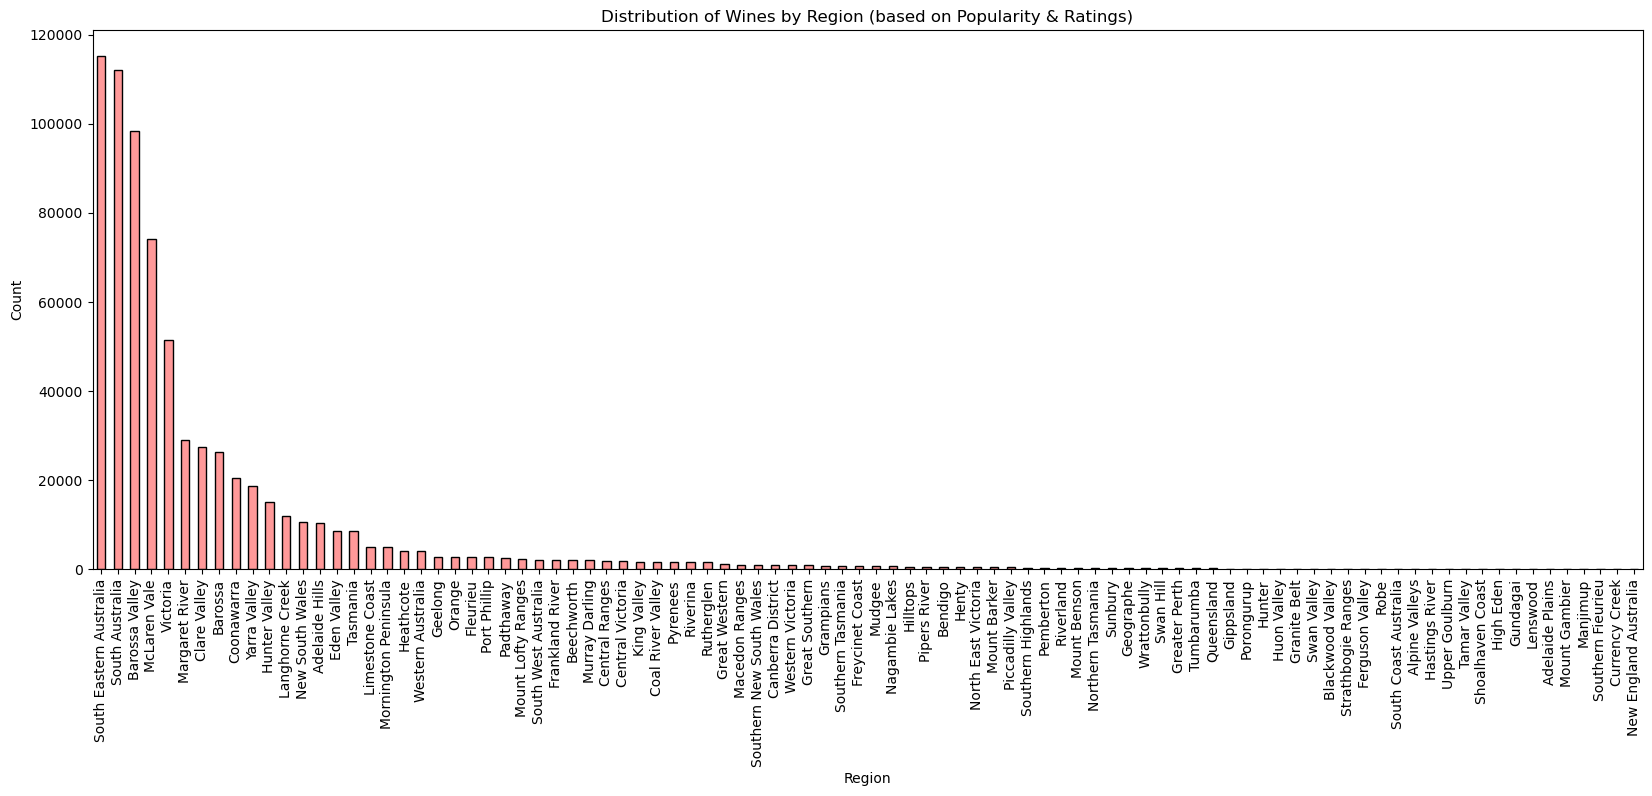

In [32]:
# Distribution of wines by region (Popularity, User Engagement)
region_counts = australian_wines_ratings['RegionName'].value_counts()

plt.figure(figsize=(20, 7))
region_counts.plot(kind='bar', color='#FF9999', edgecolor='black')
plt.title('Distribution of Wines by Region (based on Popularity & Ratings)')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()


__Regional Analysis: Average wine ratings by region (based on Popularity, User Engagement)__

Let's create a __bar plot__ to visualize the __average wine ratings by region__ in `australian_wines` by applying `seaborn`. Thus, it highlights the average rating for wines from each region. This offers valuable insights into the __perceived quality of wines from different regions__.

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/1806274346.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ratings_by_region.index, y=avg_ratings_by_region.values, palette='muted')


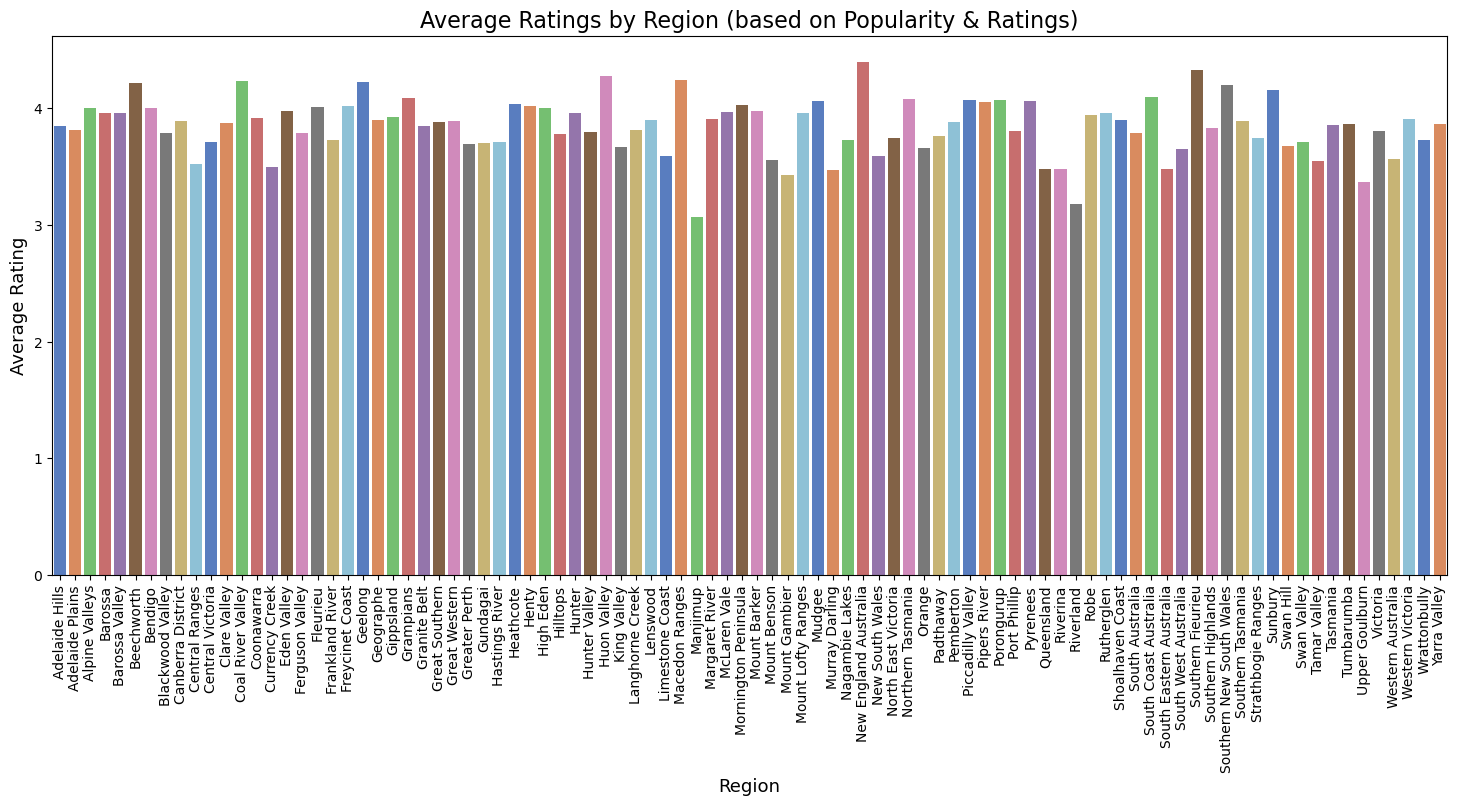

In [33]:
# Average ratings by region
avg_ratings_by_region = australian_wines_ratings.groupby('RegionName')['Rating'].mean()

plt.figure(figsize=(18, 7))
sns.barplot(x=avg_ratings_by_region.index, y=avg_ratings_by_region.values, palette='muted')
plt.title('Average Ratings by Region (based on Popularity & Ratings)', fontsize=16)
plt.ylabel('Average Rating', fontsize=13)
plt.xlabel('Region', fontsize=13)
plt.xticks(rotation=90)     # rotate 90 degrees for better readability
plt.show()

__Regional Analysis: Top 10 Regions by Number of Wines (Variety Of Wines Produced)__

Let's create a __bar plot__ to visualize the distribution of the top-10 __regional players__ in `australian_wines`  by applying `seaborn`. This measures the number of __unique wines__ for each given Region. Therefore, it reflects the __variety of wines produced__ rather than their popularity.

Noticeably, __Barossa Valley__ is the leading region with 613 wines, followed by South Eastern Australia (473 wines) and South Australia (445 wines). These regions have significantly higher wine counts compared to others, which indicates that they are major wine-producing regions.


/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/2143616419.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_regions.index, y=top_regions.values, palette='muted')


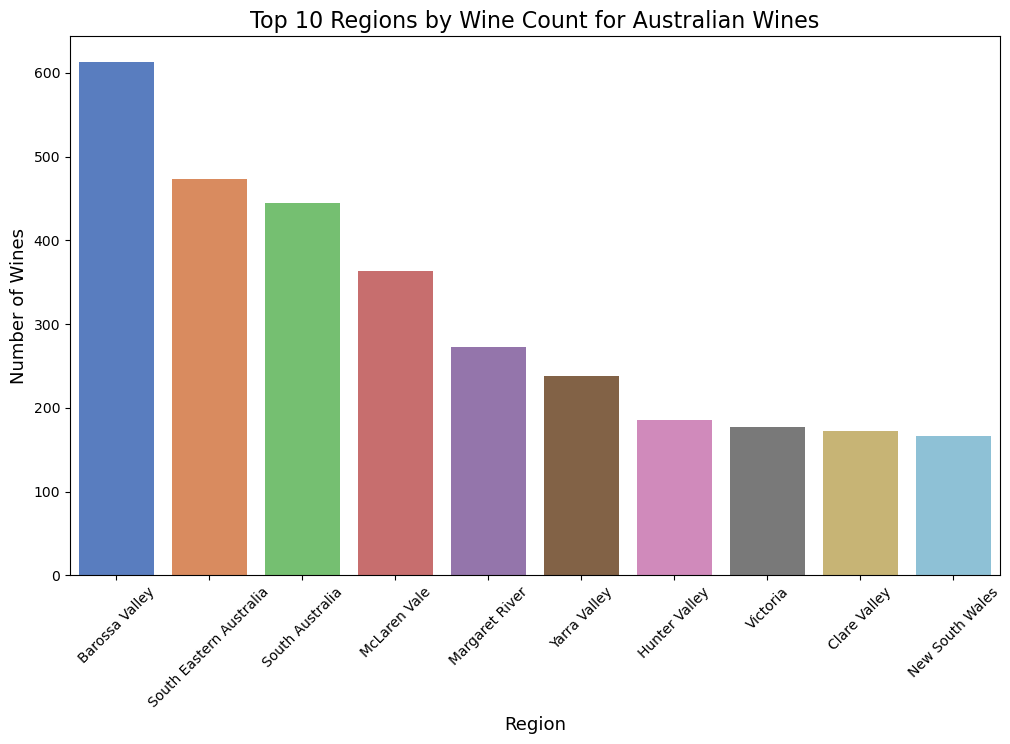

In [34]:
# Top 10 Regions by Number of Wines
top_regions = australian_wines['RegionName'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_regions.index, y=top_regions.values, palette='muted')
plt.title('Top 10 Regions by Wine Count for Australian Wines', fontsize=16)
plt.ylabel('Number of Wines', fontsize=13)
plt.xlabel('Region', fontsize=13)
plt.xticks(rotation=45)
plt.show()

__User Profiles__

Let's create __user profiles__ by aggregating various features from the merged wine ratings and wine attributes data. Thus, it provide a summary of each __user's wine preferences__ based on the wines they have rated. 

Overall, `user_profiles` provides valuable insights into user preferences, which can be used for __personalized recommendations__ and better understanding of user behavior in the context of wine ratings.

In [35]:
# Merge the wines and ratings data on WineID
merged_df = pd.merge(df_ratings, australian_wines, on='WineID')

# Ensure the 'Grapes' column is correctly formatted
if 'Grapes' in merged_df.columns:
    merged_df['Grapes'] = merged_df['Grapes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    grape_varieties = merged_df.explode('Grapes')  # handling of complex data structures (lists within a column) to extract meaningful insights

# Aggregate features by user
user_profiles = merged_df.groupby('UserID').agg({
    'ABV': 'mean',                                     # Average ABV of the wines rated by the user 
    'Type': lambda x: x.value_counts().idxmax(),       # Most common wine type rated by the user
    'Grapes': lambda x: pd.Series([grape for sublist in x for grape in sublist]).value_counts().idxmax(),  # Most common grape variety in the wines rated by the user
    'Body': lambda x: x.value_counts().idxmax(),       # Most common body characteristic of the wines rated by the user
    'Acidity': lambda x: x.value_counts().idxmax(),    # Most common acidity level of the wines rated by the user
    'RegionName': lambda x: x.value_counts().idxmax(), # Most common region of the wines rated by the user
    'WineryName': lambda x: x.value_counts().idxmax(), # Most common winery of the wines rated by the user
}).reset_index()

# Display first 5 rows
user_profiles.head()

,UserID,ABV,Type,Grapes,Body,Acidity,RegionName,WineryName
0,1000001,12.500000,White,Riesling,Light-bodied,High,Yarra Valley,Yering Station
1,1000003,15.000000,Red,Syrah/Shiraz,Very full-bodied,High,McLaren Vale,Mollydooker
2,1000004,14.634483,Red,Syrah/Shiraz,Full-bodied,High,South Australia,RedHeads
3,1000005,14.300000,Red,Syrah/Shiraz,Full-bodied,Low,Langhorne Creek,Heartland
4,1000007,14.000000,Red,Cabernet Sauvignon,Full-bodied,High,Barossa Valley,Lou Miranda


__User Profiles: Distribution of Average ABV per User__

Let's create a __histogram with a Kernel Density Estimate (KDE)__ overlay to visualize the distribution of the average Alcohol by Volume (ABV) per user in the `user_profiles`. This reveals a __high concentration of user preferences around the 13-15% ABV range__.

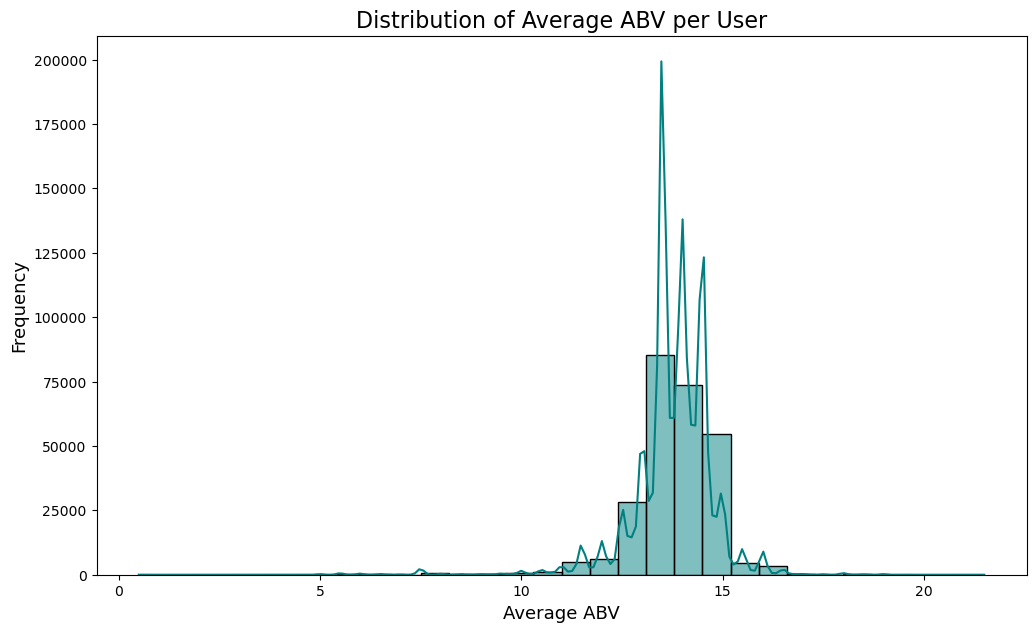

In [36]:
plt.figure(figsize=(12, 7))
sns.histplot(user_profiles['ABV'], kde=True, bins=30, color='teal', edgecolor='black')
plt.title('Distribution of Average ABV per User', fontsize=16)
plt.xlabel('Average ABV', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.show()

__Correlation Matrix of User Profiles__ 

Let's create a Correlation Matrix based on the __encoded features__, and visualise it by using a __heatmap__ plot. As a result, it is possible to easily identify and interpret significant correlations between features in the `user_profiles_encoded`.

The highest correlation (0.59) is between __Body__ and __Grapes__, suggesting that certain grape varieties are strongly associated with specific body types of wines. In second position, a correlation between __Body__ and __Type__ (0.20) indicates a moderate relationship between wine type and body.

A moderate negative correlation (-0.49) between __ABV__ and __Acidity__ suggests that wines with higher alcohol content tend to have lower acidity levels (known as inverse variation).

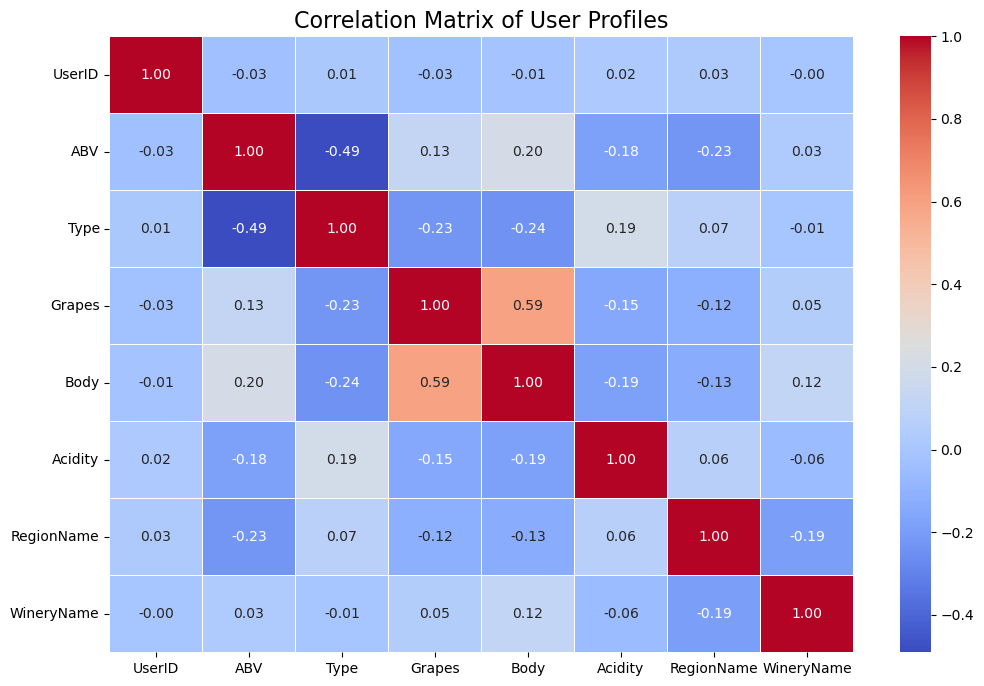

In [37]:
# Encode categorical variables
user_profiles_encoded = user_profiles.copy()
label_encoders = {}
for column in ['Type', 'Grapes', 'Body', 'Acidity', 'RegionName', 'WineryName']:
    le = LabelEncoder()
    user_profiles_encoded[column] = le.fit_transform(user_profiles_encoded[column])
    label_encoders[column] = le

# Compute the correlation matrix
correlation_matrix_user_profile = user_profiles_encoded.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_user_profile, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of User Profiles', fontsize=16)
plt.show()

__User Profiles: Most Common Wineries Rated by Users__

Let's create a __bar plot__ to visualize the most common regions rated by users in the `user_profiles`. This focuses on the number of users who have rated wines from each region, reflecting __user preferences__ from a user-centric perspective. Noticeably, __South Eastern Australia__ is the most commonly rated region.

/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/2607879180.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette='muted')


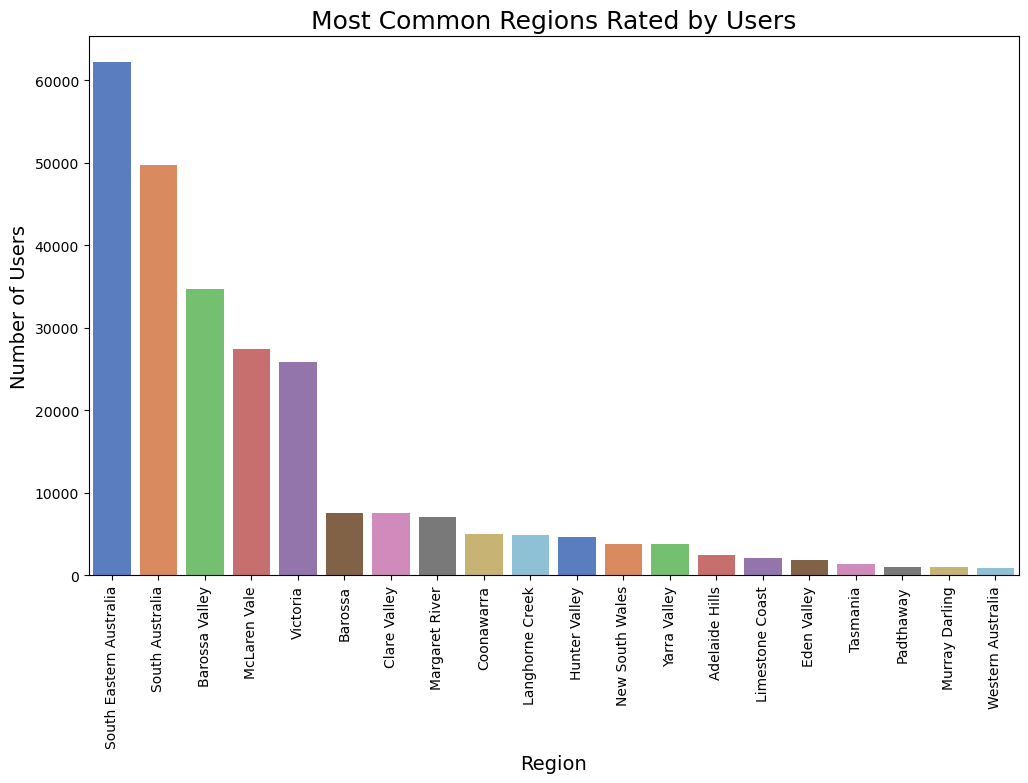

In [38]:
plt.figure(figsize=(12, 7))
region_counts = user_profiles['RegionName'].value_counts().head(20)
sns.barplot(x=region_counts.index, y=region_counts.values, palette='muted')
plt.title('Most Common Regions Rated by Users', fontsize=18)
plt.ylabel('Number of Users', fontsize=14)
plt.xlabel('Region', fontsize=14)
plt.xticks(rotation=90)
plt.show()

__User Profiles: Seasonal Trends Ratings__

Let's create a set of __bar plots__ that visualize the most common wine types rated by users in different seasons (Spring, Summer, Autumn, Winter) in `user_profiles_by_season`.

The overall __trend__ of red wines being the most popular is consistent across all seasons. In all four seasons, __red wines are the most commonly rated wine type__ by a significant margin. White wines are the second most commonly rated wine type but their counts are much lower compared to red wines. Sparkling, Rosé, and Dessert wines have relatively low counts which indicates that they are less frequently rated.

In [39]:
# Convert 'Date' to datetime
df_ratings['Date'] = pd.to_datetime(df_ratings['Date'])

# Extract month from 'Date'
df_ratings['Month'] = df_ratings['Date'].dt.month

# Function to map months to season of the year for US Eastern timezone
def month_to_season_us_eastern(month):
    '''For northern hemisphere'''
    if month in [12, 1, 2]:     # December, January, February
        return 'Winter'
    elif month in [3, 4, 5]:    # March, April, May
        return 'Spring'
    elif month in [6, 7, 8]:    # June, July, August
        return 'Summer'
    elif month in [9, 10, 11]:  # September, October, November
        return 'Autumn'
    
# Apply the function to map months to seasons
df_ratings['Season'] = df_ratings['Month'].apply(month_to_season_us_eastern)
# Filter the wines dataset for Australian wines
australian_wines_df = df_wines[df_wines['Country'] == 'Australia']

# Merge the wines and ratings data on WineID
merged_df = pd.merge(df_ratings, australian_wines_df, on='WineID')

# Aggregate features by user and season
user_profiles_by_season = merged_df.groupby(['UserID', 'Season']).agg({
    'ABV': 'mean',
    'Type': lambda x: x.value_counts().idxmax(),
    'Grapes': lambda x: pd.Series([grape for sublist in x for grape in sublist]).value_counts().idxmax(),
    'Body': lambda x: x.value_counts().idxmax(),
    'Acidity': lambda x: x.value_counts().idxmax(),
    'RegionName': lambda x: x.value_counts().idxmax(),
    'WineryName': lambda x: x.value_counts().idxmax(),
}).reset_index()

user_profiles_by_season.head()

,UserID,Season,ABV,Type,Grapes,Body,Acidity,RegionName,WineryName
0,1000001,Autumn,12.500000,White,',Light-bodied,High,Yarra Valley,Yering Station
1,1000003,Autumn,14.500000,Red,',Very full-bodied,High,McLaren Vale,Wolf Blass
2,1000003,Spring,15.500000,Red,',Very full-bodied,High,McLaren Vale,Mollydooker
3,1000003,Winter,15.000000,Red,',Very full-bodied,High,Barossa Valley,Teusner
4,1000004,Autumn,14.555556,Red,',Full-bodied,High,McLaren Vale,Mollydooker


/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/3392620472.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wine_type_counts.index, y=wine_type_counts.values, palette='muted', ax=ax)
/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/3392620472.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wine_type_counts.index, y=wine_type_counts.values, palette='muted', ax=ax)
/var/folders/g9/rh_jc__915xbjfjkzcglwdzw0000gn/T/ipykernel_4892/3392620472.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wine_type_

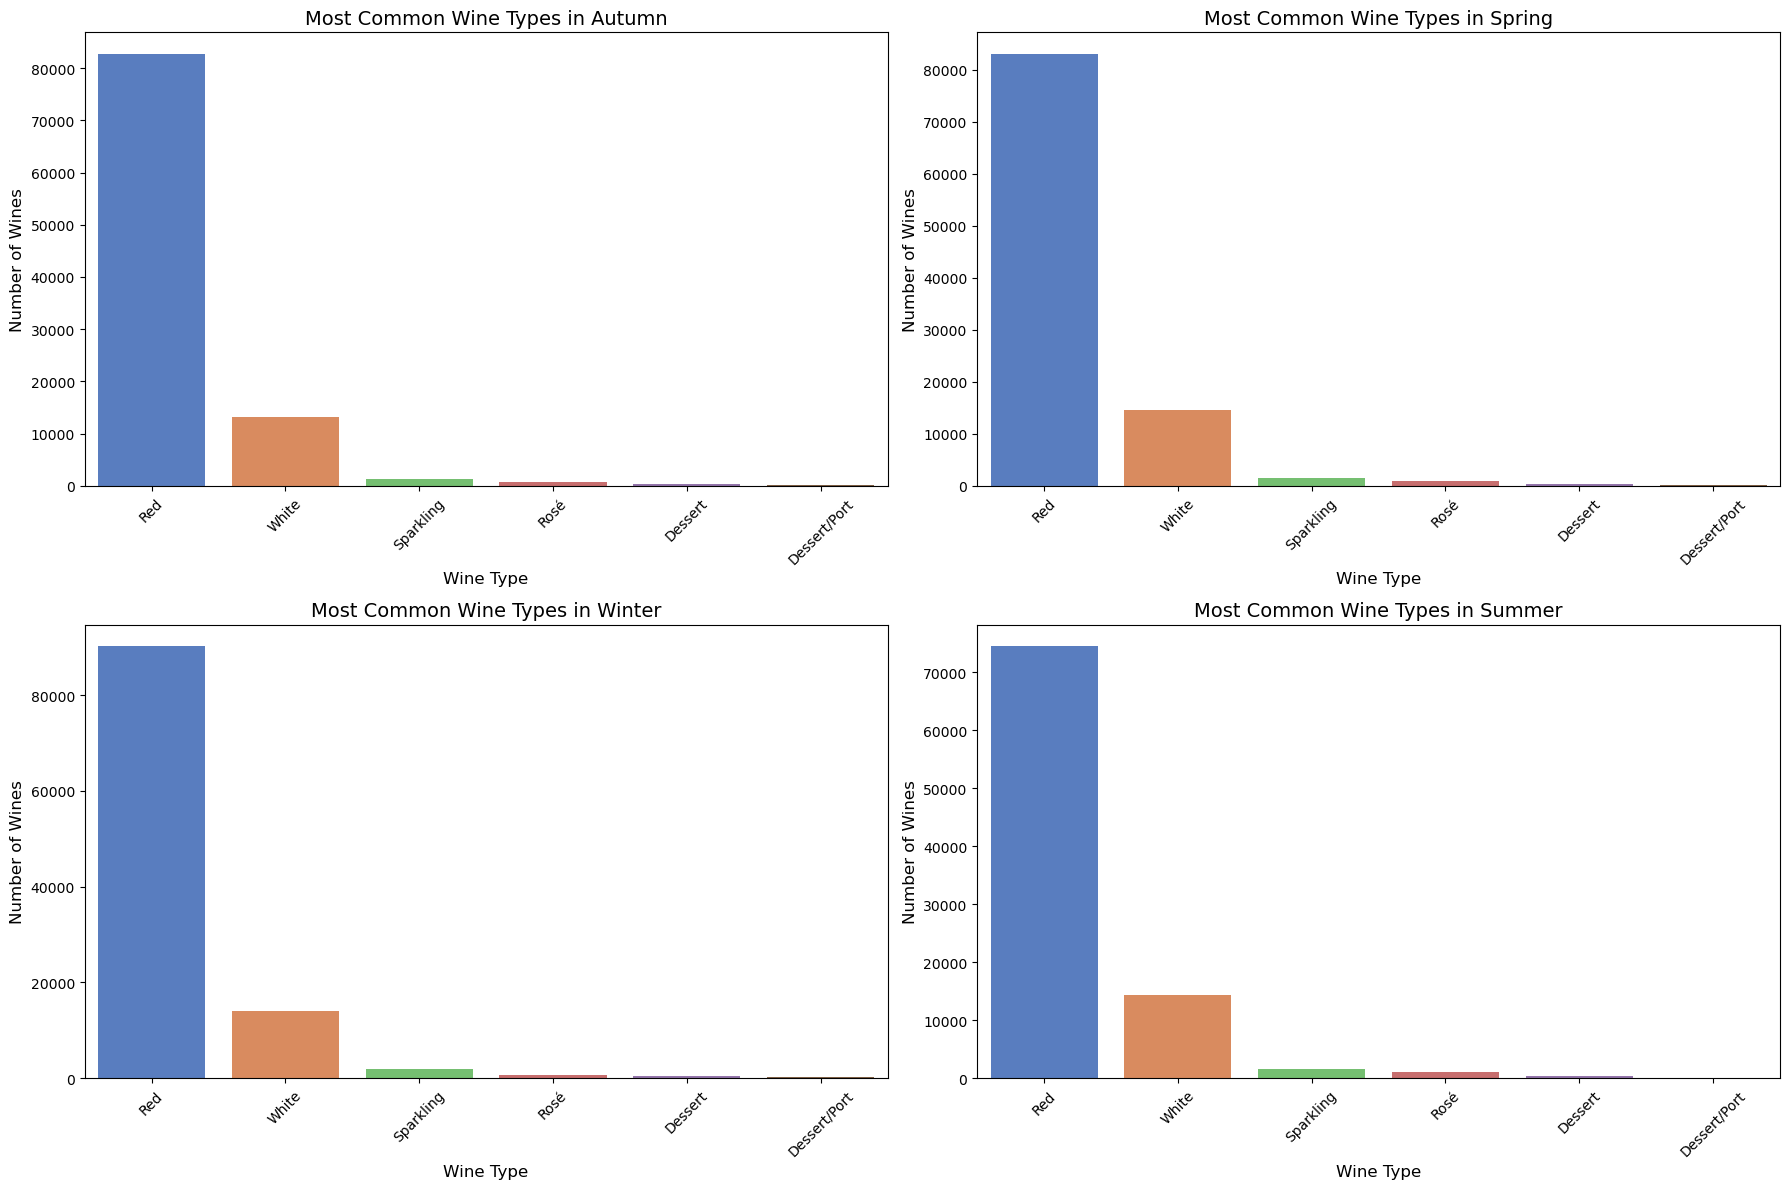

In [40]:
def plot_wine_types_by_season(ax, season, data):
    season_data = data[data['Season'] == season]
    wine_type_counts = season_data['Type'].value_counts()

    sns.barplot(x=wine_type_counts.index, y=wine_type_counts.values, palette='muted', ax=ax)
    ax.set_title(f'Most Common Wine Types in {season}', fontsize=14)
    ax.set_ylabel('Number of Wines', fontsize=12)
    ax.set_xlabel('Wine Type', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

# Plot for each season in a 2x2 grid
seasons = user_profiles_by_season['Season'].unique()
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for ax, season in zip(axes.flatten(), seasons):
    plot_wine_types_by_season(ax, season, user_profiles_by_season)

plt.tight_layout()
plt.show()

__User Analysis__

Let's create a __histogram__ that visualizes the distribution of the number of ratings by users in the `australian_wines_ratings`. The resulting plot shows the distribution of the number of ratings made by users, with the y-axis on a logarithmic scale. Below we have the following insights:

* __Skewed distribution__: The distribution is highly right-skewed, with most users making a relatively small quantity of ratings. The frequency of ratings provided by users decreases sharply as the number of ratings increases.

* __High frequency of Low Ratings__: The highest bar on the left indicates that a large number of users have made a very small number of ratings. As the number of ratings increases, the frequency of users decreases exponentially.

* __Outliers__: There are a few outliers where users have made a very high number of ratings (around 700 ratings), but these are rare.

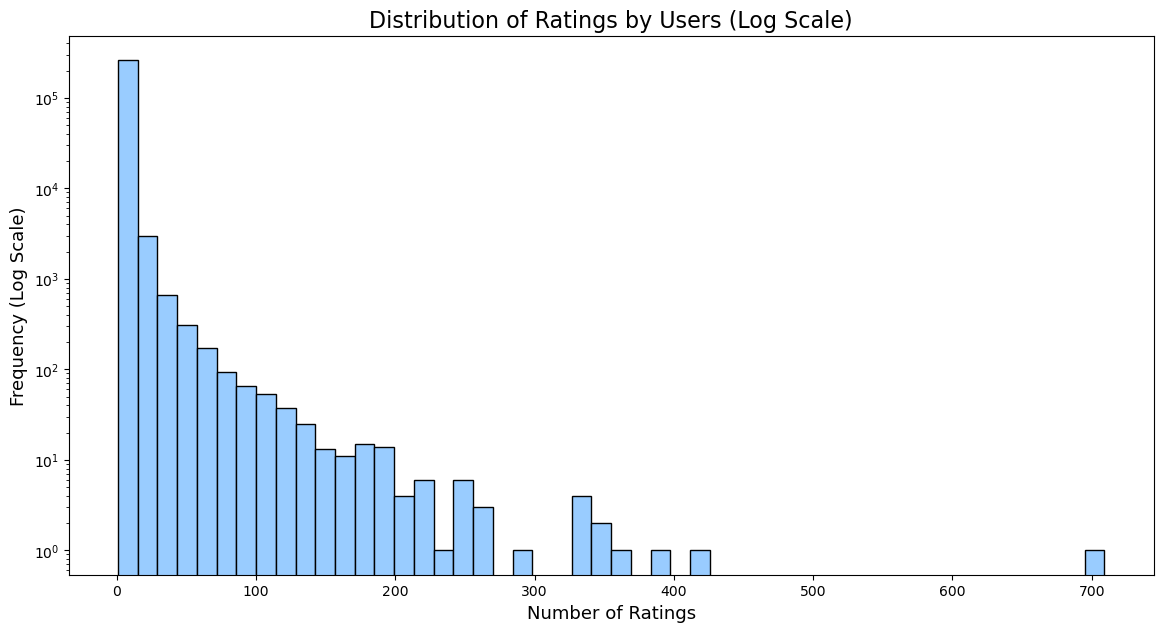

In [41]:
# Distribution of ratings by users
user_ratings_counts = australian_wines_ratings['UserID'].value_counts()

plt.figure(figsize=(14, 7))
user_ratings_counts.plot(kind='hist', bins=50, log=True, color='#99CCFF', edgecolor='black')
plt.title('Distribution of Ratings by Users (Log Scale)', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=13)
plt.ylabel('Frequency (Log Scale)', fontsize=13)
plt.show()

In [42]:
# Identify users with the most ratings
top_users = user_ratings_counts.head(10)
top_users

UserID
1264817    709
1116107    418
1653232    396
1765929    360
1002016    341
1000272    341
1058009    336
1097850    333
1000031    330
1122926    327
Name: count, dtype: int64

__Correlation Matrix__

Let's create a __correlation matrix__ for selected numeric columns in the `australian_wines_ratings`by using a __heatmap__. The color intensity and colorbar indicate the strength and direction of the correlations. Red indicates positive correlations, while blue indicates negative correlations.

Below we have the following insights:
* __WineID and WineryID__: There is a strong positive correlation (0.52) between __WineID__ and __WineryID__. This suggests that specific wines are associated with specific wineries.

* __ABV and Rating__: There is a weak positive correlation (0.16) between __ABV__ and __Rating__. This indicates that wines with higher alcohol content tend to receive slightly higher ratings.

* __Other Variables__: Most other correlations are weak (close to 0), indicating little to no linear relationship between those pairs of variables.


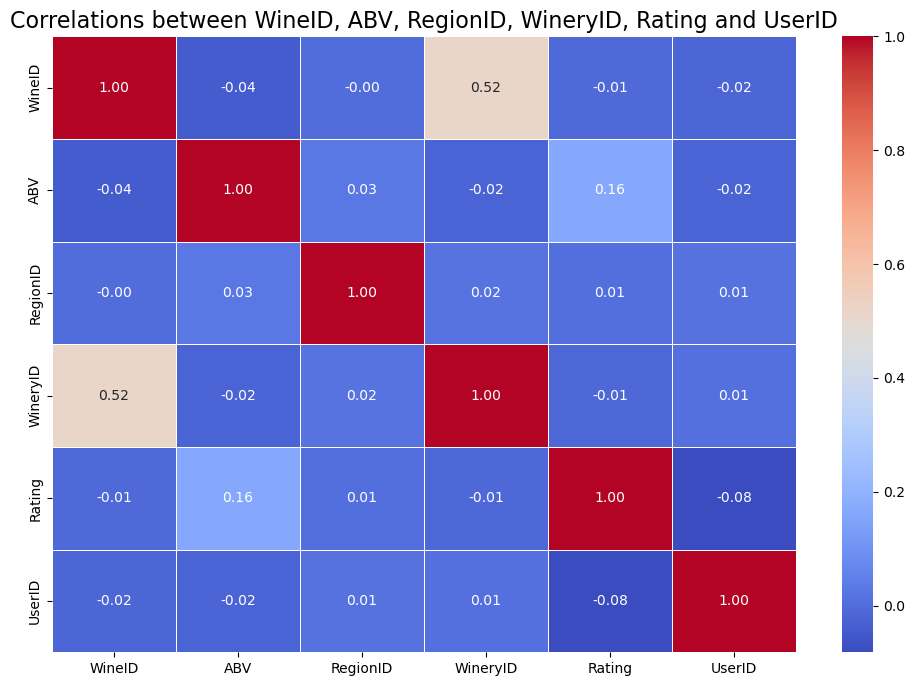

In [43]:
# correlation matrix for selected numeric columns
numeric_columns = ['WineID', 'ABV', 'RegionID', 'WineryID', 'Rating', 'UserID']
correlation_matrix = australian_wines_ratings[numeric_columns].corr()

# Visualize the correlation matrix
features_string = ', '.join(numeric_columns[:-1])
last_feature = numeric_columns[-1]
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlations between {features_string} and {last_feature}', fontsize=16)
plt.show()

__Seasonal Trend (based on Ratings)__

Let's a series of __bar plots__ to visualize the distribution of wine ratings by season in Australia, segmented by individual rating values (from 1.0 to 5.0). Each subplot represents the count of a specific rating across the four seasons: Winter, Spring, Summer and Autumn. Overall, these plots provide insights into __user engagement__ and potential __seasonal trends__. 

Below we have the following insights:
* __Seasonal Preferences__: The slight increase in Summer ratings suggests a seasonal preference or increased activity during this time. Winter and Autumn also show consistent engagement, though typically with slightly fewer ratings compared to Summer.

Notice that we use `month_to_season_us_eastern` function because the timestamps for the rating attribute is collected from the United States.

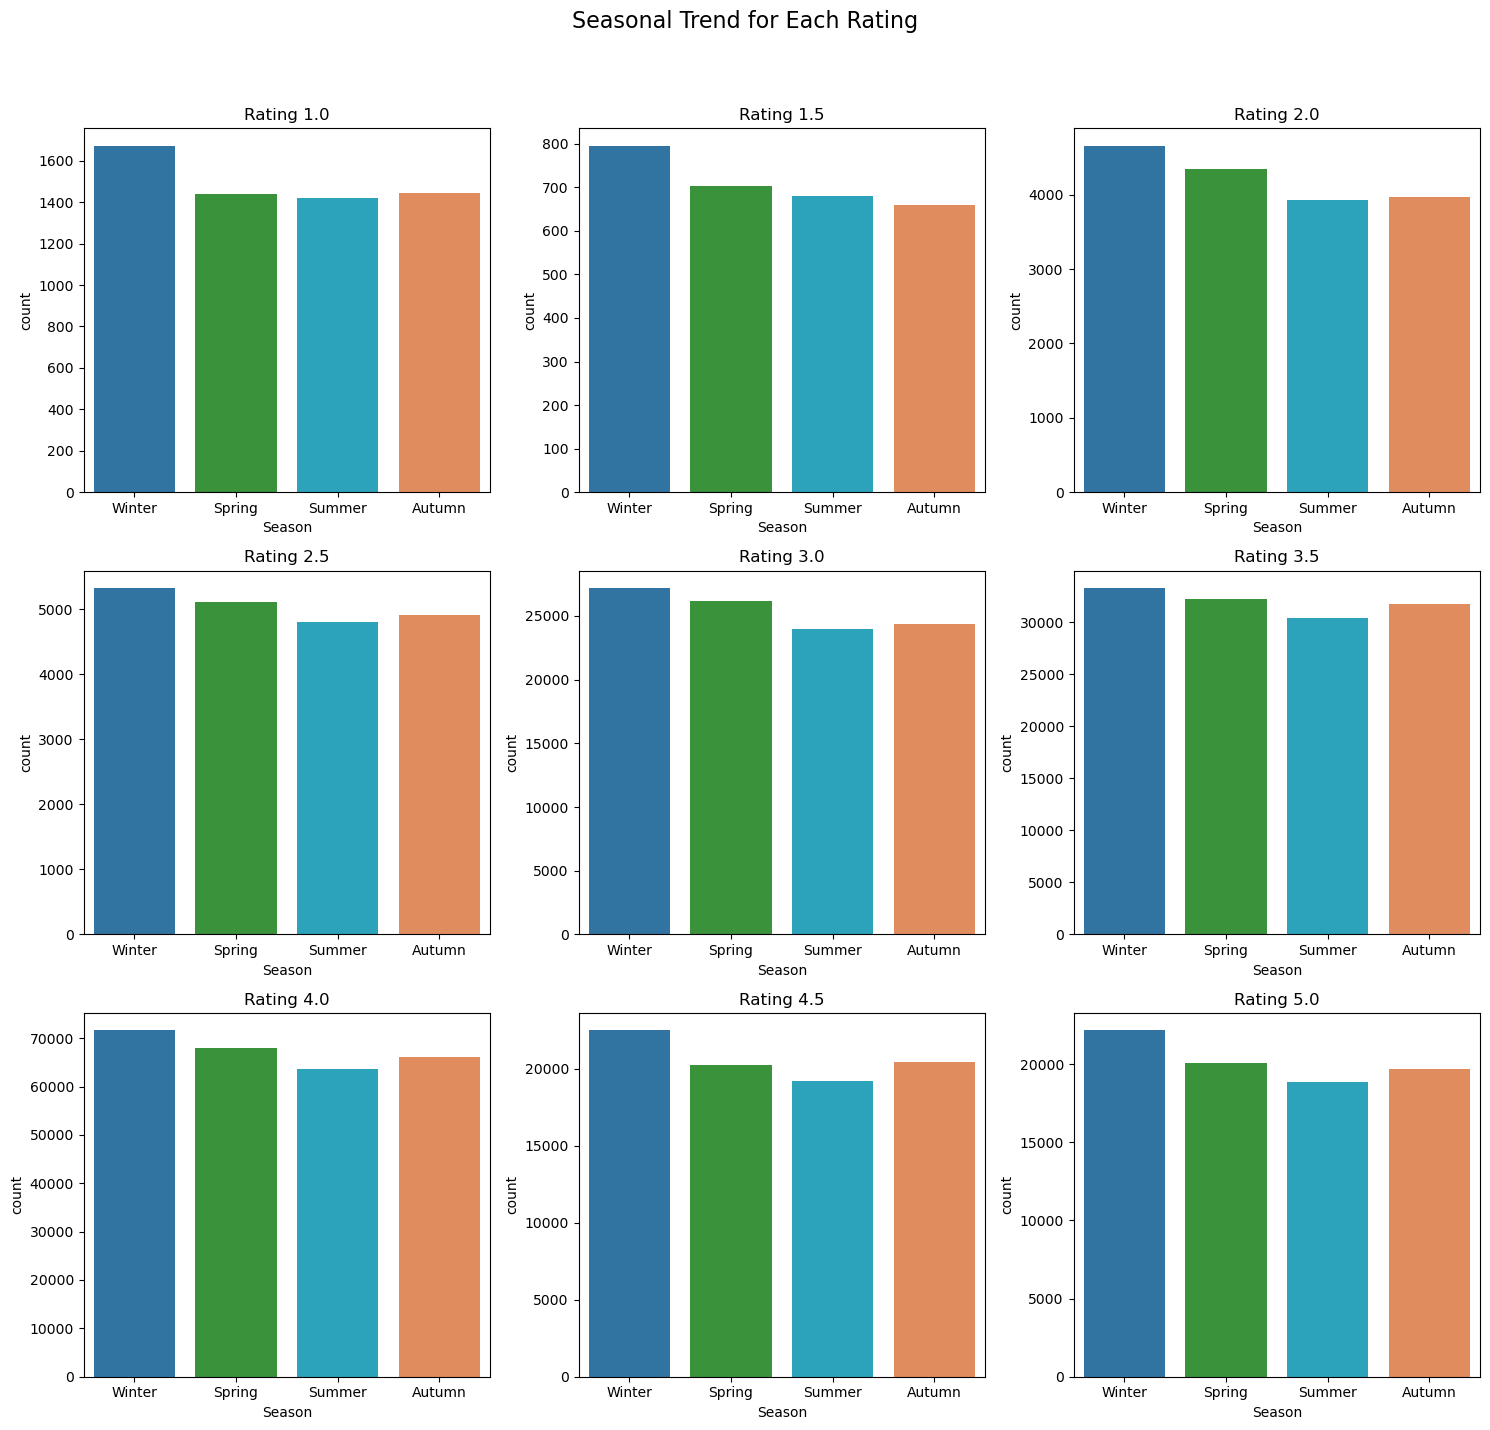

In [44]:
# Function to map months to season of the year for US Eastern timezone
def month_to_season_us_eastern(month):
    '''For northern hemisphere'''
    if month in [12, 1, 2]:     # December, January, February
        return 'Winter'
    elif month in [3, 4, 5]:    # March, April, May
        return 'Spring'
    elif month in [6, 7, 8]:    # June, July, August
        return 'Summer'
    elif month in [9, 10, 11]:  # September, October, November
        return 'Autumn'

# convert the "Date" column into "Datetime" format
australian_wines_ratings['Date'] = pd.to_datetime(australian_wines_ratings['Date'])

# extract the Month from the "Date"
australian_wines_ratings['Month'] = australian_wines_ratings['Date'].dt.month

# Apply the function to create the season_ratings column
australian_wines_ratings['Season'] = australian_wines_ratings['Month'].apply(month_to_season_us_eastern)

# Drop Month column (not needed)
australian_wines_ratings.drop('Month', axis=1, inplace=True)

# Define a consistent color palette for the seasons
season_colors = {
    'Winter': '#1f77b4',
    'Summer': '#15b2d3',
    'Spring': '#2ca02c',
    'Autumn': '#f58549'
}

# Plotting the distribution of ratings by season
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Seasonal Trend for Each Rating', fontsize=16)

# Iterate over the sorted unique ratings
unique_ratings = sorted(australian_wines_ratings['Rating'].unique())
for i, rating in enumerate(unique_ratings):
    filtered_df = australian_wines_ratings[australian_wines_ratings['Rating'] == rating]
    row, col = divmod(i, 3)
    sns.countplot(data=filtered_df, x='Season', hue='Season', palette=season_colors, order=['Winter', 'Spring', 'Summer', 'Autumn'], ax=axes[row, col], legend=False)
    axes[row, col].set_title(f'Rating {rating:.1f}')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Collaborative Filtering based on SOM

__Introduction__

__Collaborative filtering (CF)__ recommendation systems are a widely used technology in the field of recommendations. Unlike content-based methods, CF does __not require prior knowledge of user preferences__ or item features. Instead, it relies solely on __users' historical interactions__, such as browsing or purchase records. By collecting user feedback in the form of __ratings__, the system calculates __similarities__ between users. It then leverages high-similarity neighbors to predict a target user's preferences for specific items. As a result, it recommends items based on these predicted preferences.

The primary __advantage__ of CF systems is their flexibility in __handling unstructured and complex objects__, such as music, movies, and images. Compared to content-based systems, collaborative filtering offers several benefits: it can filter information that is challenging for machines to analyze, overcoming the limitations of incomplete and imprecise content analysis. Additionally, CF can __recommend new items__ by effectively utilizing feedback from similar users.

However, CF technology also faces significant challenges, particularly __data sparsity__ and __scalability__. These issues arise due to the large, sparse user-item interaction matrices and the computational complexity involved in finding similar users and items as the dataset grows. Addressing these challenges is critical to improving the performance and applicability of collaborative filtering systems in real-world scenarios.

The following section provides a detailed implementation of a Collaborative Filtering method based on Self-Organising Maps (SOM)for a wine recommender system. __SOMs__ a type of __unsupervised neural network__ architecture, are particularly adept at recognizing __complex patterns__ within data, making them highly suitable for recommendation systems. __Collaborative Filtering__ leverages __user-item interaction__ data (i.e. user-wine) to identify and suggest items that users might find appealing. 

In [46]:
# import libraries

import numpy as np                # data analysis and preparation
import pandas as pd               # data analysis and preparation
import matplotlib.pyplot as plt   # visualisation
from minisom import MiniSom       # training Self-Organising Maps (SOM)
import somoclu                    # training Self-Organising Maps (SOM
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder    # data preprocessing


If you installed Somoclu with pip on macOS, this typically means missing a linked library. If you compiled Somoclu with GCC, please make sure you have set DYLD_LIBRARY_PATH to include the GCC path. For more information, please refer to the documentation.


__Preprocessing Data: CF based on SOM__

The following preprocessing steps are crucial for structuring the data appropriately for buiding a Collaborative Filtering recommendation system. 

Let's create `preprocessText` function, which is designed to clean and standardise text data. By removing unwanted characters, normalizing whitespace, and optionally converting to lowercase, it prepares text data for further processing. 

In [47]:
import re

# Define preprocessing function
def preprocessText(text, lower=False):
    
    # Lowercase all characters
    if lower: text = text.lower()

    # replace --, ~, ... by space 
    text = re.sub(r'[\-]{1,}', ' ', text)
    text = text.replace('~', ' ')
    text = re.sub(r'[\.]{1,}', ' ', text)

    # Keep only characters and digits
    text = re.sub(r"[^a-zA-Z0-9+']", ' ', text)
    
    # remove punctuations/illegal chars from the string
    text = re.sub(r'[^\/\-$%\w\d\s]', '', text)

    # word must be at least 2 chars, remove words less than 2 chars
    text = re.sub(r'(^|\s)[\/\-$%\w\d]{1,1}(\s|$)', ' ', text)

    # remove double/trailing white spaces
    text = re.sub(r'\s+', ' ', text)

    # remove string [^$] leading and trailing whitespaces.
    text = text.strip()
    
    return text

Now we can effectively clean and standardise three attributes in our `australian_wines` dataset, in particular `'WineName'`, `'RegionName'` and `'WineryName'`. This __preprocessing__ step is crucial for ensuring data quality and consistency.

In [52]:
dataset_path = 'X-Wines_Dataset'
# df_wines = pd.read_csv(f'{dataset_path}/XWines_Slim_1K_wines.csv', low_memory=False)
# df_ratings = pd.read_csv(f'{dataset_path}/XWines_Slim_150K_ratings.csv', low_memory=False)

df_wines = pd.read_csv(f'{dataset_path}/XWines_Full_100K_wines.csv', low_memory=False)
df_ratings = pd.read_csv(f'{dataset_path}/XWines_Full_21M_ratings.csv', low_memory=False)

# Filter the DataFrame to get only Australian wines
australian_wines = df_wines[df_wines['Country'] == 'Australia']

# Get the unique identifiers for Australian wines
australian_wine_ids = australian_wines['WineID'].unique()

# Filter the df_ratings DataFrame to get only ratings for Australian wines
australian_ratings = df_ratings[df_ratings['WineID'].isin(australian_wine_ids)]

# Apply preprocessing to WineName, RegionName and WineryName  - options: to_lower (0|1)
australian_wines.loc[:, 'WineName'] = australian_wines['WineName'].apply(lambda x: preprocessText(x,1))
australian_wines.loc[:, 'RegionName'] = australian_wines['RegionName'].apply(lambda x: preprocessText(x,1))
australian_wines.loc[:, 'WineryName'] = australian_wines['WineryName'].apply(lambda x: preprocessText(x,1))


Next, we need to effectively transform the `Grapes` and `Harmonize` columns from __lists to one-hot encoded columns__. So the main ideas is to:
1. __List Conversion__: Convert the string representations of lists into actual lists, enabling list oprations.

2. __Column Explosion__: Flatten the `Grapes` and `Harmonize` attributes so that each list element gets its own row. This makes it easier to create __dummy variables__.

3. __Dummy Variable Creation__: One-hot encodes the `Grapes` and `Harmonize` attributes. This creates binary columns for each unique value in these lists.

4. __Data Aggregation__: Aggregates data into a single row per wine. This ensures that each wine has a binary indicator for each grape and harmonize element.

In [53]:
import ast

australian_wines.loc[:, 'Grapes'] = australian_wines['Grapes'].map(lambda x: ast.literal_eval(x))
australian_wines.loc[:, 'Harmonize'] = australian_wines['Harmonize'].map(lambda x: ast.literal_eval(x))

df_expanded = australian_wines.explode('Grapes').explode('Harmonize')

# Create dummies for both columns
df_grapes_dummies = pd.get_dummies(df_expanded['Grapes'])
df_harmonize_dummies = pd.get_dummies(df_expanded['Harmonize'])

australian_wines = pd.concat([df_expanded.drop(columns=['Grapes', 'Harmonize']), df_grapes_dummies, df_harmonize_dummies], axis=1).groupby('WineID').max().reset_index()


Let's further inspect our `australian_ratings` DataFrame. As you can notice, we have multiple `N.V.` values in Vintage columns which assumes to contain only years as values.

In [54]:
australian_ratings

,RatingID,UserID,WineID,Vintage,Rating,Date
144,145,1166116,174189,1950,3.0,2019-12-03 04:12:50
160,161,1362181,174189,1950,4.0,2020-10-31 21:09:09
176,177,1943003,174184,1951,5.0,2021-02-25 19:20:50
672,673,1121586,174184,1953,5.0,2017-11-20 12:44:15
867,868,1718475,174184,1955,5.0,2013-04-28 19:08:23
...,...,...,...,...,...,...
21013248,21013249,2039684,174401,N.V.,4.0,2019-09-10 11:19:06
21013309,21013310,1204655,174376,N.V.,3.5,2016-11-12 12:39:27
21013319,21013320,1144757,175200,N.V.,4.0,2014-11-22 14:31:03
21013398,21013399,1189937,175711,N.V.,2.0,2020-05-19 08:38:20


Hence, we will handle Non-Vintage values by replacing every instance of `N.V.` with `-1`. Finally, we make sure to convert the `Vintage` attribute to __integer type__.

In [58]:
# Replace "N.V." with -1 in the Vintage column
australian_ratings.loc[:, 'Vintage'] = australian_ratings['Vintage'].replace('N.V.', -1)
australian_ratings.loc[:, 'Vintage'] = australian_ratings['Vintage'].astype(int)

Next step in our preprocessing is to allow for __seasonal analysis of wine ratings__. This can rpovide insights into __user behavior and preferences__ across different times of the year.

In [61]:
# Function to map months to season of the year for US Eastern timezone
def month_to_season_us_eastern(month):
    '''For northern hemisphere'''
    if month in [12, 1, 2]:     # December, January, February
        return 'Winter'
    elif month in [3, 4, 5]:    # March, April, May
        return 'Spring'
    elif month in [6, 7, 8]:    # June, July, August
        return 'Summer'
    elif month in [9, 10, 11]:  # September, October, November
        return 'Autumn'
    
australian_ratings = australian_ratings.copy()
# convert the "Date" column into "Datetime" format
australian_ratings['Date'] = pd.to_datetime(australian_ratings['Date'])

# extract the Month from the "Date"
australian_ratings['Month'] = australian_ratings['Date'].dt.month

# Apply the function to create the season_ratings column
australian_ratings['Season'] = australian_ratings['Month'].apply(month_to_season_us_eastern)

# Drop Month column (not needed)
australian_ratings.drop('Month', axis=1, inplace=True)

australian_ratings

,RatingID,UserID,WineID,Vintage,Rating,Date,Season
144,145,1166116,174189,1950,3.0,2019-12-03 04:12:50,Winter
160,161,1362181,174189,1950,4.0,2020-10-31 21:09:09,Autumn
176,177,1943003,174184,1951,5.0,2021-02-25 19:20:50,Winter
672,673,1121586,174184,1953,5.0,2017-11-20 12:44:15,Autumn
867,868,1718475,174184,1955,5.0,2013-04-28 19:08:23,Spring
...,...,...,...,...,...,...,...
21013248,21013249,2039684,174401,-1,4.0,2019-09-10 11:19:06,Autumn
21013309,21013310,1204655,174376,-1,3.5,2016-11-12 12:39:27,Autumn
21013319,21013320,1144757,175200,-1,4.0,2014-11-22 14:31:03,Autumn
21013398,21013399,1189937,175711,-1,2.0,2020-05-19 08:38:20,Spring


Next, we will extracts relevant features for further processing and analysis. This step focuses on the wine attributes (for instance, `WineName`, `RegionName`, `WineryName`, `ABV`, `Grapes`, `Harmonize` etc) while excluding identifiers and potentially redundant information, such as `'WineID'` and `'Country'`. 

In [62]:
# Extract the relevant columns
features = australian_wines.drop(columns=['WineID', 'Country'])
ratings = australian_ratings.copy()  # ensure the original data is not modified

We need to distinguish attributes between __categorical__ and __numerical__ columns and then apply __one-hot encoding__ to the categorical columns. Specifically, one-hot encoding transforms categorical variables into a format that can be provided to the machine learning algorithm (in this case, SOM) to improve its performance. Essentially, each unique category value becomes a new column, with binary indicators (0 or 1) representing the presence of each category value.

In [64]:
# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object', 'bool']).columns
numerical_cols = features.select_dtypes(include=['number']).columns

# One-hot encode categorical columns
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = one_hot_encoder.fit_transform(features[categorical_cols])

This preprocessing step ensures that all features are appropriately __scaled__ and __encoded__. By normalizing numerical features, we ensure that each feature __contributes equally__ to the model. This prevents features with __larger ranges from dominating__ the learning process. Additionally, normalisation will improve the convergence speed of gradient-based optimisation algorithms (which is the case for SOM, a type of artificial neural network used for unsupervised learning), leading to __faster and more stable convergence__. Finally, normalisation also improves the __quality of clusters__, producing more meaninful and interpretable clusters. 

In [65]:
# Normalize the numerical features
scaler = MinMaxScaler()
normalized_numerical_features = scaler.fit_transform(features[numerical_cols])

# Combine numerical and encoded categorical features
normalized_features = np.hstack([normalized_numerical_features, encoded_categorical])

Next, we will effectively organise __user ratings by season__, by using a dictionary data structure. This allows for easy access and analysis of ratings for each specific season.

In [67]:
# Create a dictionary to map user ratings for each season
seasonal_data = {season: ratings[ratings['Season'] == season] for season in ['Winter', 'Spring', 'Summer', 'Autumn']}

This preprocessing step ensures that the data is ready for input into SOM (machine learning model) enabling __season-specific analysis__ and recommendations. Specifically, the relevant features (both categorical and numerical) are extracted, encoded, and normalised to maintain consistency.

In [68]:
# Prepare normalized features for each season
seasonal_normalized_features = {}
for season, seasonal_ratings in seasonal_data.items():
    merged_data = seasonal_ratings.merge(australian_wines, on='WineID')
    seasonal_features = merged_data[categorical_cols.tolist() + numerical_cols.tolist()]
    
    seasonal_encoded_categorical = one_hot_encoder.transform(seasonal_features[categorical_cols])
    seasonal_normalized_numerical_features = scaler.transform(seasonal_features[numerical_cols])
    
    seasonal_normalized_features[season] = np.hstack([seasonal_normalized_numerical_features, seasonal_encoded_categorical])

The following code is design to __train a Self-Organizing Map (SOM)__ for a given set of features. It allows for customisation of the SOM grid size, sigma, learning rate, and the number of iterations. This function provides a flexible and effective method for training SOMs on seasonal data, which enables clustering and visualisation of high-dimensional features.

Let's have a quick look in the following input parameters for `train_som` function:
* `features`: The input features to train the SOM.

* `som_size`: A tuple specifying the size of the SOM grid.

* `sigma`: The spread of the neighbourhood function.

* `learning_rate`: The learning rate for training.

* `iterations`: The number of iterations for training.

In [70]:
# Function to train SOM for each season
def train_som(features, som_size=(10, 10), sigma=0.5, learning_rate=0.5, iterations=100):
    som = MiniSom(x=som_size[0], y=som_size[1], input_len=features.shape[1], sigma=sigma, learning_rate=learning_rate)
    som.random_weights_init(features[:1000])
    som.train_random(features, iterations)
    return som

Now let's put our model in action. The following code will train a Self-Organising Map (SOM) for each season using the `train_som` function. It effectievly stores the trained SOMs in a dictionary for easy access and seasonal/trend analysis. 

In [71]:
# Train SOMs for each season
soms = {}
for season, features in seasonal_normalized_features.items():
    soms[season] = train_som(features)

Next, we will define `recommend_wines` function that generates personalised wine recommendations for a given user and season based on the trained Self-Organising Map (SOMs). Essentially, this function generates personalised wine recommendations based on the __user's past ratings__ and the __seasonal SOM__. It ensures that __wines already rated by the user are excluded__ from the recommendations. Finally, it uses __clusters identified by the SOM__ to find similar wines (__"Best Matching"__). 

Let's have a quick look in the following input parameters for `train_som` function:
* `user_id`: Recommendations are to be generated for a specific User ID.

* `season`: The season for which recommendations are needed.

* `soms`: A dictionary containing trained SOMs for each season.

* `df_wines`: DataFrame containing wine features.

* `df_ratings`: DataFrame containing user ratings.

* `top_n`: The number of recommendations to generate.

In [72]:
# Function to generate personalized recommendations for a given user and season
def recommend_wines(user_id, season, soms, df_wines, df_ratings, top_n=10):
    som = soms[season]
    user_ratings = df_ratings[df_ratings['UserID'] == user_id]
    if user_ratings.empty:
        return []

    user_rated_wines = user_ratings['WineID'].values
    user_rated_wine_features = df_wines[df_wines['WineID'].isin(user_rated_wines)].drop(columns=['WineID', 'Country'])

    # Get the columns used one-hot encoding fit
    user_rated_wine_features = user_rated_wine_features[categorical_cols.tolist() + numerical_cols.tolist()]

    # One-hot encode
    user_encoded_categorical = one_hot_encoder.transform(user_rated_wine_features[categorical_cols])
    user_numerical_features = user_rated_wine_features[numerical_cols]
    
    # Normalize user-rated wine features
    normalized_user_numerical_features = scaler.transform(user_numerical_features)
    normalized_user_features = np.hstack([normalized_user_numerical_features, user_encoded_categorical])

    # Get the BMUs for the user's rated wines  (obs: BMU = Best Matching Units)
    user_bmus = np.array([som.winner(feat) for feat in normalized_user_features])

    # Find clusters based on user BMUs         (obs: BMU = Best Matching Units)
    clusters = np.array([som.winner(feat) for feat in normalized_features])
    cluster_ids = clusters[:, 0] * som.get_weights().shape[1] + clusters[:, 1]

    # Find the unique clusters corresponding to the user's BMUs    (obs: BMU = Best Matching Units)
    user_clusters = np.unique(user_bmus[:, 0] * som.get_weights().shape[1] + user_bmus[:, 1])

    # Get recommendations from these clusters, ?? excluding the wines already rated by the user | good to discover new wines but!!
    wine_ids_set = set(df_wines['WineID'])
    user_rated_set = set(user_rated_wines)
    recommendations = []

    for cluster in user_clusters:
        if len(recommendations) >= top_n:
            break
        cluster_indices = np.where(cluster_ids == cluster)[0]
        # Remove wines recommended by user ?? 
        cluster_wines = set(df_wines.iloc[cluster_indices]['WineID']).difference(user_rated_set)
        recommendations.extend(cluster_wines)

    # Recommended wine IDs
    recommended_wine_ids = list(set(recommendations))[:top_n]

    return recommended_wine_ids

Now, let's put our recommender in action. The `recommend_wines` function will test by randomly selecting a `UserID` and generating wine recommendations for `Winter` season. Notice that, `%%timeit` magic command is used to measure how long it takes to generate recommendations, which is useful for evaluating the performance of the recommender system.

In [78]:
# %%timeit
# Randomly select a user ID from the Australian ratings dataset and Set the current season to 'Winter'.
current_season = 'Winter'
user_id = australian_ratings['UserID'].sample(1).values[0]
recommended_wines = recommend_wines(user_id, current_season, soms, australian_wines, australian_ratings)
print(f'Recommended wines for user {user_id} in {current_season}: {recommended_wines}')

Recommended wines for user 1076973 in Winter: [189885, 190513, 190517, 174181, 174185, 174188, 174189, 174195, 174199, 174200]


Let's retrieve the __human-readable wines' names__ of the recommended wines by filtering the `df_wines` DataFrame based on the `WineID` atttribute in the `recommended_wines` list.

In [80]:
wine_names = df_wines[df_wines['WineID'].isin(recommended_wines)]['WineName'].tolist()
wine_names

['The Boxer Shiraz',
 'The Black Stump Durif-Shiraz',
 "Angels' Share Shiraz",
 'Bin 50 Shiraz',
 'Y Series Shiraz-Viognier',
 'Double Barrel Shiraz',
 'Blue Eyed Boy Shiraz',
 'Forefathers McLaren Vale Shiraz',
 'Sygnet Shiraz',
 'Never Have I Ever Pinot Noir']

The following code retrieves and displays all ratings for a specific user from the `australian_ratings` DataFrame. More specificaly, it filters the DataFrame based on a chosen `UserID` and selects relevant wine's attributes for display. This approach allows for a focused and detailed view of the __user's ratings__, which facilitates analysis of their __wine preferences__ and __rating behavior__.

In [81]:
# Display all ratings for UserID = 1556504
user_id = 1219020            
user_ratings = australian_ratings[australian_ratings['UserID'] == user_id][['WineID', 'Rating', 'Vintage', 'Date', 'Season']]
# pd.set_option('display.max_rows', None)
user_ratings

,WineID,Rating,Vintage,Date,Season
17607310,174177,3.5,2018,2021-03-01 20:36:26,Spring
17982161,174367,3.0,2018,2021-08-06 17:07:35,Summer
19320719,174242,3.0,2019,2021-01-16 19:04:28,Winter
20025679,175336,3.5,2020,2021-09-22 17:31:55,Autumn
20115680,174912,3.0,2020,2021-10-15 16:47:53,Autumn
20191596,174756,3.5,2020,2021-06-04 18:11:19,Summer
20418252,174267,3.5,2020,2021-11-29 20:40:55,Autumn
20445227,174474,3.5,2020,2021-05-18 18:47:07,Spring
20564464,174648,3.0,2021,2021-08-20 17:22:30,Summer
20567440,174185,4.0,2021,2021-12-10 17:06:15,Winter


Let's perform another recommendation for a different user for winter time.

In [82]:
# Set the current season to 'Winter' and specify the user ID as 1223086.
current_season = 'Winter'
user_id = 1223086
recommended_wines = recommend_wines(user_id, current_season, soms, australian_wines, australian_ratings)
print(f'Recommended wines for user {user_id} in {current_season}: {recommended_wines}')

Recommended wines for user 1223086 in Winter: [189885, 190513, 190517, 174185, 174188, 174189, 174191, 174195, 174199, 174201]


In [86]:
wine_names = df_wines[df_wines['WineID'].isin(recommended_wines)]['WineName'].tolist()
wine_names

['Koonunga Hill Chardonnay',
 'Bin 311 Chardonnay',
 'Legacy Fresh & Fruity White',
 'Chardonnay Diamond Label',
 'Lookout Ridge Chardonnay',
 'Eden Valley Chardonnay',
 'Unwooded Chardonnay',
 'Organic Chardonnay',
 'Hawker Corner Chardonnay',
 'Organic Chardonnay']

Similarly, let's perform wine recommendation for __spring__ time.

In [87]:
# Set the current season to 'Spring' and specify the user ID as 1223086.
current_season = 'Spring'
user_id = 1223086
recommended_wines = recommend_wines(user_id, current_season, soms, australian_wines, australian_ratings)
print(f'Recommended wines for user {user_id} in {current_season}: {recommended_wines}')

Recommended wines for user 1223086 in Spring: [177796, 176900, 174863, 177559, 178204, 175010, 176803, 174761, 176431, 178098]


In [88]:
wine_names = df_wines[df_wines['WineID'].isin(recommended_wines)]['WineName'].tolist()
wine_names

['Black Shiraz',
 'Alicante Bouschet',
 'Sparkling Shiraz',
 'The Tight Cluster Sparkling Shiraz',
 'Mc Sparkling Shiraz',
 "Gert's Blend Sparkling Shiraz",
 'E & E Black Pepper Sparkling Shiraz',
 'Silentium Sparkling Shiraz',
 'Chocolate Box Strawberry Sparkling Shiraz',
 'E&E Shiraz Sparkling']

Similarly, let's perform wine recommendation for __summer__ time.

In [89]:
# Set the current season to 'Summer' and specify the user ID as 1223086.
current_season = 'Summer'
user_id = 1223086
recommended_wines = recommend_wines(user_id, current_season, soms, australian_wines, australian_ratings)
print(f'Recommended wines for user {user_id} in {current_season}: {recommended_wines}')

Recommended wines for user 1223086 in Summer: [178185, 178199, 178201, 178222, 178224, 178233, 178236, 178249, 176204, 178276]


In [90]:
wine_names = df_wines[df_wines['WineID'].isin(recommended_wines)]['WineName'].tolist()
wine_names

['Grenache-Shiraz Rosé',
 'Outback Jack Classic Dry Red',
 'All Day Rosé',
 'Cellar Reserve Cabernet-Shiraz-Merlot',
 'Three Vines Shiraz-Grenache-Sangiovese Rosé',
 'Museum Reserve 50 Year Old Tawny Port',
 'Shiraz Rosé',
 'La Bohème The Missing Act Cabernet Sauvignon-Sangiovese',
 'Peace By Peace Red',
 'Pepperjack Grenache Rosé']

Similarly, let's perform wine recommendation for __autumn__ time.

In [91]:
# Set the current season to 'Autumn' and specify the user ID as 1223086.
current_season = 'Autumn'
user_id = 1223086
recommended_wines = recommend_wines(user_id, current_season, soms, australian_wines, australian_ratings)
print(f'Recommended wines for user {user_id} in {current_season}: {recommended_wines}')

Recommended wines for user 1223086 in Autumn: [178819, 177031, 178952, 176269, 178574, 174612, 174236, 175008, 174501, 178597]


In [92]:
wine_names = df_wines[df_wines['WineID'].isin(recommended_wines)]['WineName'].tolist()
wine_names

['Koonunga Hill Chardonnay',
 'Bin 311 Chardonnay',
 'Legacy Fresh & Fruity White',
 'Chardonnay Diamond Label',
 'Lookout Ridge Chardonnay',
 'Eden Valley Chardonnay',
 'Unwooded Chardonnay',
 'Organic Chardonnay',
 'Hawker Corner Chardonnay',
 'Organic Chardonnay']

In summary, we have seen the integration of CF with SOM not only refines the process of identifying and __clustering similar user ratings__ but also strengthens the recommendation system's __scalability__. Specifically, SOM provide a robust method for dimensionality reduction which segments the complext dataset into more manageable clusters without losing significant information. This enhances the efficiency and scalability of the CF recommender. 

### Content-based Filtering (CBF)

__Introduction__

__Content-based__ recommendation systems can effectively address __cold-start problem__ by leveraging user and item description files. This enables recommendations even when user interaction data (i.e. __user profile__) is __sparse__ or __non-existent__. Noticeably, these systems do __not rely on user ratings__ data, which avoids the issues associated with sparse datasets. It can also recommend new or less popular items. 

However, a significant drawback is the need for easily extractable and __well-structured features__ from content. This is challenging, particularly for multimedia content (e.g., graphics, video, music) and other unstructured data. Additionally, content-based systems tend to recommend items similar to those __already visited or liked by users__, based on their description files. This can restrict users to a narrow range of interests, recommending a __less diversity__ range of options.

Content-based filtering (CBF) recommender systems operate on the principle that items with similar characteristics will receive similar ratings from users. These systems recommend items that are close to those the __user has liked in the past__ by analysing the specific __features and attributes of the items__ themselves. This method focuses on the __content of the items to predict user preferences__. Thus, it provides personalised recommendations.

__CBF Implementation 1: Regression__

The following section provides a detailed implementation of a proof-of-concept of a Content-based Filtering method for a wine recommender system. It is based on various __regression models__ for __user rating predictions on similar items' attributes__ (i.e. wines' characteristics). In particular, __Support Vector Machine (SVM)__, __Linear Regression__ and __Random Forest__ are used. __Content-based Filtering (CBF)__ leverages features of items that the user has shown interest in.

First, let's create a new function called `train_and_evaluate`. Essentially, this function __trains__ and __evaluates__ __multiple regression models__ by taking training and test data as input arguments. Then, it fits the models and compute the Mean Squared Error (MSE) for each model. As a result, this function will return a dictionary data structure where each model is associated with its respective MSE value. 

But why do we choose MSE as the evaluation metric? Well, MSE penalizes __larger errors more than smaller ones__ due to the squaring of the error term as shown in the formula below. This property is useful in regression tasks where larger errors are more problemetic than smaller ones. By squaring the difference, MSE ensures that models that produce larger errors are heavily penalised. Hence, it encourages the model to reduce such errors.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$



In [3]:
# Model Training and Evaluation
def train_and_evaluate(X_train, y_train, X_test, y_test):
    models = {
        "SVM": SVR(),
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor()
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        results[name] = mse
    
    return results

Let's create another function called `make_recommendations`. This function generates personalised wine recommendations for a given user and season. Notice that __only recommendations of wines which are not rated by this user__ are taken into account. To do so, the function identifies the best model for the given season. Then, it trains the best model on the filtered dataset for that season. Next, it predicts ratings for all wines taht the user has not rated yet. Finally, it returns the `top_n` recommended wines based on the predicted ratings.

In [4]:
# Function to make recommendations using the best model
def make_recommendations(user_id, season, top_n=10):
    best_model_name = best_models[season]
    X = seasonal_normalized_features[season]
    season_ratings = seasonal_data[season]
    
    model_map = {
        "SVM": SVR(),
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor()
    }
    model = model_map[best_model_name]
    
    # Train the best model on the entire season data
    model.fit(X, season_ratings['Rating'])
    
    # Predict ratings for all wines
    all_wine_ids = australian_wines['WineID'].unique()
    user_rated_wine_ids = season_ratings[season_ratings['UserID'] == user_id]['WineID'].unique()
    unrated_wine_ids = np.setdiff1d(all_wine_ids, user_rated_wine_ids)
    
    # Prepare features for unrated wines
    unrated_wines = australian_wines[australian_wines['WineID'].isin(unrated_wine_ids)]
    unrated_features = unrated_wines[categorical_cols.tolist() + numerical_cols.tolist()]
    unrated_encoded_categorical = one_hot_encoder.transform(unrated_features[categorical_cols])
    unrated_normalized_numerical_features = scaler.transform(unrated_features[numerical_cols])
    unrated_normalized_features = np.hstack([unrated_normalized_numerical_features, unrated_encoded_categorical])
    
    # Predict ratings for unrated wines
    predicted_ratings = model.predict(unrated_normalized_features)
    
    # Get top N recommendations
    top_indices = np.argsort(predicted_ratings)[-top_n:]
    top_wine_ids = unrated_wine_ids[top_indices]
    
    return australian_wines[australian_wines['WineID'].isin(top_wine_ids)]

Now we have all the key functions to generate recommendations using CBF strategy. However, before we start doing some recommendations, we need to make sure that the dataset is properly preprocessed for the given task.

__Preprocessing Dataset for CBF__

Let's get start by performing the appropriate preprocessing phase. Essentially, we are given the option to work with either the __Full Wine Dataset__ or the __Reduced Wine Dataset__. Be aware, the Full Wine Dataset is __extremely large__, thus the training part took around __10 hours__ to complete. Next, we filter from a board option of country sources only Australian wines and ratings as defined by `australian_wines` and `australian_ratings`, respectively. The following key concepts are applying in overall preprocessing pipeline:
1. __Data Cleaning__: Standardising text data and converting string representations of lists into actual lists. Also it handles missing or special values.

2. __Feature Engineering__: One-hot encoding categorical features to convert them into numerical format. Additionally, it normalises numerical features to ensure they are on a similar scale. Thus, it avoids the machine learning models from overfitting.

3. __Seasonal Data Segmentation__: Grouping data based on seasons to account for potential seasonal trends and preferences in wine ratings.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import re
import ast

# Load data (Full Dataset)
# dataset_path = 'X-Wines_Dataset/'
# df_wines = pd.read_csv(f'{dataset_path}/XWines_Full_100K_wines.csv', low_memory=False)
# df_ratings = pd.read_csv(f'{dataset_path}/XWines_Full_21M_ratings.csv', low_memory=False)

# Load data (Reduced Dataset)
dataset_path = '/Users/yaseminsilen/Downloads/X-Wines_Dataset/'
df_wines = pd.read_csv(dataset_path + 'XWines_Slim_1K_wines.csv', low_memory=False)
df_ratings = pd.read_csv(dataset_path + 'XWines_Slim_150K_ratings.csv', low_memory=False)

# Filter the DataFrame to get only Australian wines
australian_wines = df_wines[df_wines['Country'] == 'Australia']
australian_wine_ids = australian_wines['WineID'].unique()
australian_ratings = df_ratings[df_ratings['WineID'].isin(australian_wine_ids)]

# Define preprocessing function
def preprocessText(text, lower=False):
    if lower: text = text.lower()
    text = re.sub(r'[\-]{1,}', ' ', text)
    text = text.replace('~', ' ')
    text = re.sub(r'[\.]{1,}', ' ', text)
    text = re.sub(r"[^a-zA-Z0-9+']", ' ', text)
    text = re.sub(r'[^\/\-$%\w\d\s]', '', text)
    text = re.sub(r'(^|\s)[\/\-$%\w\d]{1,1}(\s|$)', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Apply preprocessing
australian_wines['WineName'] = australian_wines['WineName'].apply(lambda x: preprocessText(x,1))
australian_wines['RegionName'] = australian_wines['RegionName'].apply(lambda x: preprocessText(x,1))
australian_wines['WineryName'] = australian_wines['WineryName'].apply(lambda x: preprocessText(x,1))

australian_wines['Grapes'] = australian_wines['Grapes'].map(lambda x: ast.literal_eval(x))
australian_wines['Harmonize'] = australian_wines['Harmonize'].map(lambda x: ast.literal_eval(x))

df_expanded = australian_wines.explode('Grapes').explode('Harmonize')
df_grapes_dummies = pd.get_dummies(df_expanded['Grapes'])
df_harmonize_dummies = pd.get_dummies(df_expanded['Harmonize'])

australian_wines = pd.concat([df_expanded.drop(columns=['Grapes', 'Harmonize']), df_grapes_dummies, df_harmonize_dummies], axis=1).groupby('WineID').max().reset_index()

# Replace "N.V." with -1 in the Vintage column
australian_ratings['Vintage'] = australian_ratings['Vintage'].replace('N.V.', -1).astype(int)

def month_to_season_us_eastern(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

australian_ratings['Date'] = pd.to_datetime(australian_ratings['Date'])
australian_ratings['Month'] = australian_ratings['Date'].dt.month
australian_ratings['Season'] = australian_ratings['Month'].apply(month_to_season_us_eastern)
australian_ratings.drop('Month', axis=1, inplace=True)

# Extract relevant columns
features = australian_wines.drop(columns=['WineID', 'Country'])
ratings = australian_ratings.copy()

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object', 'bool']).columns
numerical_cols = features.select_dtypes(include=['number']).columns

# One-hot encode categorical columns
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = one_hot_encoder.fit_transform(features[categorical_cols])

# Normalize the numerical features
scaler = MinMaxScaler()
normalized_numerical_features = scaler.fit_transform(features[numerical_cols])

# Combine numerical and encoded categorical features
normalized_features = np.hstack([normalized_numerical_features, encoded_categorical])

# Create season-specific datasets
seasonal_data = {season: ratings[ratings['Season'] == season] for season in ['Winter', 'Spring', 'Summer', 'Autumn']}
seasonal_normalized_features = {}
for season, seasonal_ratings in seasonal_data.items():
    merged_data = seasonal_ratings.merge(australian_wines, on='WineID')
    seasonal_features = merged_data[categorical_cols.tolist() + numerical_cols.tolist()]
    seasonal_encoded_categorical = one_hot_encoder.transform(seasonal_features[categorical_cols])
    seasonal_normalized_numerical_features = scaler.transform(seasonal_features[numerical_cols])
    seasonal_normalized_features[season] = np.hstack([seasonal_normalized_numerical_features, seasonal_encoded_categorical])

Finally, let's put our CBF recommender in action! We can start by evaluating each model for each season separately. As a result, we can display the evaluation results and determine the __best model for each season__ based on the __lowest MSE__ score.  

In [6]:
# Evaluate models for each season
results = {}
best_models = {}
for season in seasonal_data.keys():
    season_ratings = seasonal_data[season]
    X = seasonal_normalized_features[season]
    y = season_ratings['Rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    season_results = train_and_evaluate(X_train, y_train, X_test, y_test)
    results[season] = season_results
    
    best_model_name = min(season_results, key=season_results.get)
    best_models[season] = best_model_name

# Print results and best models
for season, season_results in results.items():
    print(f"Results for {season}:")
    for model, mse in season_results.items():
        print(f"  {model}: MSE = {mse}")
    print(f"Best model for {season}: {best_models[season]}")

Results for Winter:
  SVM: MSE = 0.2839404022586293
  Linear Regression: MSE = 1.1293342427371485e+24
  Random Forest: MSE = 0.2924043778555501
Best model for Winter: SVM
Results for Spring:
  SVM: MSE = 0.2603125473588788
  Linear Regression: MSE = 1.199668802173958e+24
  Random Forest: MSE = 0.2545122426187891
Best model for Spring: Random Forest
Results for Summer:
  SVM: MSE = 0.3316055509001783
  Linear Regression: MSE = 3.355958779703979e+23
  Random Forest: MSE = 0.31857297600154244
Best model for Summer: Random Forest
Results for Autumn:
  SVM: MSE = 0.34264996096230416
  Linear Regression: MSE = 0.33825910852310503
  Random Forest: MSE = 0.3332641453369229
Best model for Autumn: Random Forest


__CBF Implementation 2: Classification__

In the previous section, we have demonstrated how to approach a Content-based Filtering (CBF) recommender by using regression models for predicting the actual ratings. However, in the following section we will implement the same strategy but with some different techniques. More specifically, we will structure our __CBF recommender__ as a __binary classification__ problem for predicting either high or low ratings for a given user. To do so, we will relying on __TF-IDF features__ extracted from __grape descriptions__. As a result, wine recommendations will be displayed based on __probabilities__ oh high ratings using a __Random Forest classifier__. 

Let's obtain the dataset required to build the model for the CBF recommender. Again, we are given the option to work with either the __Full Wine Dataset__ or the __Reduced Wine Dataset__. Be aware, the Full Wine Dataset is __extremely large__. Addtionally, we will need to effectively preprocess the text data in different columns.

In [16]:
# Load data (Full Dataset)
# dataset_path = 'X-Wines_Dataset/'
# df_wines = pd.read_csv(f'{dataset_path}/XWines_Full_100K_wines.csv', low_memory=False)
# df_ratings = pd.read_csv(f'{dataset_path}/XWines_Full_21M_ratings.csv', low_memory=False)

# Load data (Reduced Dataset)
dataset_path = 'X-Wines_Dataset/'
df_wines = pd.read_csv(dataset_path + 'XWines_Slim_1K_wines.csv', low_memory=False)
df_ratings = pd.read_csv(dataset_path + 'XWines_Slim_150K_ratings.csv', low_memory=False)

# Filter the DataFrame to get only Australian wines
australian_wines = df_wines[df_wines['Country'] == 'Australia']

# Get the unique identifiers for Australian wines
australian_wine_ids = australian_wines['WineID'].unique()

# Filter the df_ratings DataFrame to get only ratings for Australian wines
australian_ratings = df_ratings[df_ratings['WineID'].isin(australian_wine_ids)]

# Replace "N.V." with -1 in the Vintage column
australian_ratings.loc[:, 'Vintage'] = australian_ratings['Vintage'].replace('N.V.', -1)
australian_ratings.loc[:, 'Vintage'] = australian_ratings['Vintage'].astype(int)

def month_to_season_us_eastern(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# Create new column to associate each rating for a specific season of the year
australian_ratings = australian_ratings.copy()
australian_ratings['Date'] = pd.to_datetime(australian_ratings['Date'])
australian_ratings['Month'] = australian_ratings['Date'].dt.month
australian_ratings['Season'] = australian_ratings['Month'].apply(month_to_season_us_eastern)
australian_ratings.drop('Month', axis=1, inplace=True)

# Merge the ratings with the wine features
australian_wines_ratings = pd.merge(australian_ratings, australian_wines, on="WineID")

# Remove duplicates
australian_wines_ratings.drop_duplicates(subset=['WineID', 'Rating', 'Date'], inplace=True)

# Apply preprocessText function
australian_wines_ratings['cleaned_name'] = australian_wines_ratings['WineName'].apply(preprocessText)
australian_wines_ratings['cleaned_type'] = australian_wines_ratings['Type'].apply(preprocessText)
australian_wines_ratings['cleaned_elaborate'] = australian_wines_ratings['Elaborate'].apply(preprocessText)
australian_wines_ratings['cleaned_grapes'] = australian_wines_ratings['Grapes'].apply(lambda x: ' '.join(eval(x)))
australian_wines_ratings['cleaned_harmonize'] = australian_wines_ratings['Harmonize'].apply(lambda x: ' '.join(eval(x)))


Next, we will need to create a new column named `rating_label` to apply __label encoding__ technique. To do so, we will convert the wine ratings into binary labels (represented as `0` or `1`) based on whether they are above or below the overall median rating in the dataset. Additionally, we will use __TF-IDF Vectorization__, which convert `cleaned_grapes` text data into numerical features for modeling as shown in the formula below. As a result, we will use the `tfidf_matrix` as input features (predictor variables) and the created `rating_label` as the target variable (variable that the model is trying to classify). 

But TF-IDF vector is used for the CBF? By combining both __Term Frequency (TF)__ and __Inverse Document Frequency (IDF)__ scores, we are able to easily identify relevant terms that can better represent the content of an item (a particular wine in this case). In fact, TF-IDF helps in reducing the dimensionality of the text data by focusing on significant terms and ignoring irrelevant or less informative ones.

__TF-IDF Formula__

The TF-IDF score for a term $t$ in a document $ d $ within a corpus $ D $ is calculated as follows:
$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

where:

- $\text{TF}(t, d)$ is the Term Frequency of term $ t $ in document $ d $ defined as:
  $$
  \text{TF}(t, d) = \frac{f_{t,d}}{N_d}
  $$
  where $ f_{t,d} $ is the frequency of term $ t $ in document $ d $, and $ N_d $ is the total number of terms in document $ d $.

- $\text{IDF}(t, D)$ is the Inverse Document Frequency of term $ t $ in corpus $ D $ defined as:
  $$
  \text{IDF}(t, D) = \log\left(\frac{N}{|\{d \in D : t \in d\}|}\right)
  $$
  where $ N $ is the total number of documents in the corpus $ D $, and $ |\{d \in D : t \in d\}| $ is the number of documents in which term $ t $ appears.


In [19]:
# Encode wine ratings as binary labels for classification
australian_wines_ratings['rating_label'] = (australian_wines_ratings['Rating'] > australian_wines_ratings['Rating'].median()).astype(int)

# Use TF-IDF matrix as features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(australian_wines_ratings['cleaned_grapes'])

# Combine TF-IDF matrix with other features if needed
X = tfidf_matrix
y = australian_wines_ratings['rating_label']

Let's effectively train and evaluate on multiple classification models (__Logistic Regression__, __Support Vector Classifier__, __Random Forest__, __K-Nearest Neighbors__, __Decision Tree__, and __Gradient Boosting__) on the training data. Then, we will compute their accuracies on the test data.

In [24]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Logistic Regression Accuracy: {accuracy_logreg:.2f}')

# Support Vector Classifier
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f'Support Vector Classifier Accuracy: {accuracy_svc:.2f}')

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Classifier Accuracy: {accuracy_rf:.2f}')

# K-Nearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbors Classifier Accuracy: {accuracy_knn:.2f}')

# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Classifier Accuracy: {accuracy_dt:.2f}')

# Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Classifier Accuracy: {accuracy_gb:.2f}')

Logistic Regression Accuracy: 0.79
Support Vector Classifier Accuracy: 0.79
Random Forest Classifier Accuracy: 0.79
K-Nearest Neighbors Classifier Accuracy: 0.80
Decision Tree Classifier Accuracy: 0.79
Gradient Boosting Classifier Accuracy: 0.79


Let's create a new function called `get_recommendations_by_grape_type_rf`. This function will get the recommendations based on a specific grape type using the trained Random Forest classifier `rf`. As a result, it predicts the probabilities of a high rating wine instance amongst all wines and sorts them based on these probabilities.

In [25]:
# Function to get wine recommendations based on grape type using Random Forest Classifier
def get_recommendations_by_grape_type_rf(grape_type, model=rf, tfidf_matrix=tfidf_matrix):
    # Find wines containing the specified grape type
    wines_with_grape = australian_wines_ratings[australian_wines_ratings['cleaned_grapes'].str.contains(grape_type, case=False)]

    if wines_with_grape.empty:
        print("No wines found with the specified grape type.")
        return pd.DataFrame()

    # Get the index of the wines that match the grape type
    indices = wines_with_grape.index

    # Predict the probability of high rating for all wines
    probabilities = model.predict_proba(tfidf_matrix)[:, 1]

    # Combine probabilities with the wine data
    australian_wines_ratings['Probability'] = probabilities

    # Filter wines by the specified grape type and sort by probability, ensuring no duplicates by wine name
    recommended_wines = australian_wines_ratings.loc[indices]
    recommended_wines = recommended_wines.sort_values(by='Probability', ascending=False).drop_duplicates(subset='WineName').head(10)
    return recommended_wines

Now, let's put the recommendation in action! 

In [27]:
# Example: Get recommendations based on a specific grape type using Random Forest Classifier
grape_type = 'Shiraz'  # Example grape type
recommendations_rf = get_recommendations_by_grape_type_rf(grape_type)
print("\nRecommendations based on Shiraz using Random Forest Classifier:")

# Display recommendations using Random Forest Classifier and its respective probabilities
recommendations_rf[['WineName', 'Grapes', 'Country', 'Probability']]


Recommendations based on Shiraz using Random Forest Classifier:


,WineName,Grapes,Country,Probability
0,Grange,['Syrah/Shiraz'],Australia,0.652753
1348,Reserve Shiraz,['Syrah/Shiraz'],Australia,0.652753
1341,Shiraz,['Syrah/Shiraz'],Australia,0.652753
1338,The Factor,['Syrah/Shiraz'],Australia,0.652753
1287,Mill Cellars Shiraz,['Syrah/Shiraz'],Australia,0.652753
1373,Shiraz Rosé,['Syrah/Shiraz'],Australia,0.652753
1394,Single Vineyard Shiraz,['Syrah/Shiraz'],Australia,0.652753
789,E & E Black Pepper Shiraz,['Syrah/Shiraz'],Australia,0.652753
1936,The Riddle Shiraz Rosé,['Syrah/Shiraz'],Australia,0.652753
1996,Abednego Shiraz-Grenache-Mourvedre,"['Syrah/Shiraz', 'Grenache', 'Mourvedre']",Australia,0.283469


In [12]:
# Apply preprocessing
df_wines['WineName'] = df_wines['WineName'].apply(lambda x: preprocessText(x, 1))
df_wines['RegionName'] = df_wines['RegionName'].apply(lambda x: preprocessText(x, 1))
df_wines['WineryName'] = df_wines['WineryName'].apply(lambda x: preprocessText(x, 1))
df_wines['Grapes'] = df_wines['Grapes'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all text columns are in lowercase for consistency
df_wines['Type'] = df_wines['Type'].str.lower()
df_wines['Grapes'] = df_wines['Grapes'].apply(lambda x: [grape.lower() for grape in x] if isinstance(x, list) else x)
df_wines['Harmonize'] = df_wines['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_wines['Harmonize'] = df_wines['Harmonize'].apply(lambda x: [item.lower() for item in x] if isinstance(x, list) else x)

# Extract unique values for each relevant column
wine_types = df_wines['Type'].unique().tolist()
grapes = df_wines['Grapes'].explode().unique().tolist()
harmonize_options = df_wines['Harmonize'].explode().unique().tolist() if 'Harmonize' in df_wines.columns else []

print("Wine Types:", wine_types)
print("Grapes:", grapes)
print("Harmonize Options:", harmonize_options)

Wine Types: ['sparkling', 'red', 'white', 'dessert/port', 'dessert', 'rosé']
Grapes: ['muscat/moscato', 'ancellotta', 'cabernet sauvignon', 'merlot', 'muscat/moscato bianco', 'touriga nacional', 'syrah/shiraz', 'arinto de bucelas', 'loureiro', 'trajadura', 'tinta barroca', 'tinta amarela', 'touriga franca', 'tinta roriz', 'tinto cão', 'tannat', 'malvasia', 'nebbiolo', 'malbec', 'chardonnay', 'riesling', 'glera/prosecco', 'pinot noir', 'viognier', 'muscat/moscato giallo', 'muscat of hamburg', 'petit verdot', 'riesling itálico', 'niagara blanc', 'alicante bouschet', 'aragonez', 'trincadeira', 'castelão', 'tinta miúda', 'camarate', 'alfrocheiro preto', 'baga', 'rufete', 'alvarinho', 'sousão', 'tibouren', 'arinto', 'azal branco', 'borraçal', 'espadeiro', 'vinhão', 'seara nova', 'fernão pires', 'palomino', 'pedro ximenez', 'tinta francisca', 'maria gomes', 'alvarelhão', 'rabo de ovelha', 'bical', 'verdelho', 'síria', 'azal tinto', 'padeiro', 'tinta negra mole', 'rabigato', 'viosinho', 'malv

In [13]:
# Interactive questionnaire function for new customers
def get_user_preferences(wine_types, df_wines, harmonize_options):
    print("Please answer the following questions to help us recommend the best wines for you.")
    
    wine_types_input = input(f"Favorite Wine Types (e.g., {', '.join(wine_types)}): ").strip().lower().split(', ')
    
    # Filter grapes based on selected wine types
    filtered_grapes = df_wines[df_wines['Type'].isin(wine_types_input)]
    filtered_grapes = filtered_grapes['Grapes'].explode().unique().tolist()
    print(f"Available Grapes for selected wine types ({', '.join(wine_types_input)}): {', '.join(filtered_grapes)}")
    
    grapes_input = input(f"Preferred Grapes (e.g., {', '.join(filtered_grapes)}): ").strip().lower().split(', ')
    
    harmonize_input = input(f"Harmonize with (e.g., {', '.join(harmonize_options)}): ").strip().lower().split(', ') if harmonize_options else []

    # Return collected preferences as a dictionary
    return {
        'wine_types': wine_types_input,
        'grapes': grapes_input,
        'harmonize': harmonize_input
    }

### Reference

[1] A. Sharma, G. P. Dubey, H. K. Shakya. __Hybrid Filtering Techniques and Improved SOM for Next-Generation Film Recommendations__. 2024. International Journal of Intelligent Systems and Applications in Engineering, 12(3), 3477–3484. https://www.ijisae.org/index.php/IJISAE/article/view/5982.

[2] J. Sill, G. Takács, L. Mackey, D. Lin. __Feature-Weighted Linear Stacking__. 2009. https://arxiv.org/abs/0911.0460. 

[3] K. Falk. __Practical recommender systems__. 2019. Simon and Schuster.

[4] P. Harrington. __Machine Learning in Action__. 2012. Manning Publications Co., USA.

[5] S. Galli. __Python Feature Engineering Cookbook__. 2020. Packt Publishing.

[6] Z. Ma, Y. Yang, F. Wang, C. Li and L. Li, __The SOM Based Improved K-Means Clustering Collaborative Filtering Algorithm in TV Recommendation System__, 2014 Second International Conference on Advanced Cloud and Big Data, Huangshan, China, 2014, pp. 288-295, https://doi:10.1109/CBD.2014.45.
